## 1 Importy i pobranie danych

In [ ]:
# Numpy
import numpy as np

# Pandas
import pandas as pd

# Reprezentacja graficzna
import seaborn as sns
import matplotlib.pyplot as plt

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin


# Uczenie płytkie
from sklearn.model_selection import train_test_split
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# StandardScaler 
from sklearn.preprocessing import StandardScaler

# inne
from scipy.stats.distributions import uniform, randint
import math

# Uczenie głębokie
from tensorflow import keras
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras import layers
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Dense



In [ ]:
data = pd.read_csv("data.csv")

In [ ]:
data.head(5)

,Unnamed: 0,Date,Location,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,6049,2009-01-01,Cobar,0.0,12.0,12.3,SSW,48.0,ENE,SW,...,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No
1,6050,2009-01-02,Cobar,0.0,14.8,13.0,S,37.0,SSE,SSE,...,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No
2,6051,2009-01-03,Cobar,0.0,10.8,10.6,NNE,46.0,NNE,NNW,...,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No
3,6052,2009-01-04,Cobar,0.0,11.4,12.2,WNW,31.0,WNW,WSW,...,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No
4,6053,2009-01-05,Cobar,0.0,11.2,8.4,WNW,35.0,NW,WNW,...,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,No,No




*   Data - The date of observation
*   Location - The common name of the location of the weather station
*   Rainfall - The amount of rainfall recorded for the day in mm
*   Evaporation - The so-called Class A pan evaporation (mm) in the 24 hours to 9am
*   Sunshine - The number of hours of bright sunshine in the day.
*   WindGustDir - The direction of the strongest wind gust in the 24 hours to midnight
*   WindGustSpeed - The speed (km/h) of the strongest wind gust in the 24 hours to midnight
*   WindDir9am - Direction of the wind at 9am
*   WindDir3pm - Direction of the wind at 3pm
*   WindSpeed9am- Wind speed (km/hr) averaged over 10 minutes prior to 9am
*   WindSpeed3pm -Wind speed (km/hr) averaged over 10 minutes prior to 3pm
*   Humidity9am - Humidity (percent) at 9am
*   Humidity3pm - Humidity (percent) at 3pm
*   Pressure9am - Atmospheric pressure (hpa) reduced to mean sea level at 9am
*   Pressure3pm - Atmospheric pressure (hpa) reduced to mean sea level at 3pm
*   Cloud9am - Fraction of sky obscured by cloud at 9am. This is measured in "oktas", which are a unit of eigths. It records how many
*   Cloud3pm - Fraction of sky obscured by cloud (in "oktas": eighths) at 3pm. See Cload9am for a description of the values
*   Temp9am - Temperature (degrees C) at 9am
*   Temp3pm - Temperature (degrees C) at 3pm
*   RainToday - Boolean: 1 if precipitation (mm) in the 24 hours to 9am exceeds 1mm, otherwise 0
*   RainTomorrow
The amount of next day rain in mm. Used to create response variable RainTomorrow. A kind of measure of the "risk".


## 2 Przygotowanie danych
Na początku sprawdźmy ile i gdzie są wartości nullowe



In [ ]:
# ile i gdzie wartości nullowe
data.isnull().sum()

Unnamed: 0         0
Date               0
Location         191
Rainfall           5
Evaporation        0
Sunshine           0
WindGustDir      182
WindGustSpeed      0
WindDir9am       860
WindDir3pm       223
WindSpeed9am      12
WindSpeed3pm       3
Humidity9am       14
Humidity3pm       13
Pressure9am       23
Pressure3pm       16
Cloud9am           0
Cloud3pm           0
Temp9am            2
Temp3pm            0
RainToday          5
RainTomorrow       0
dtype: int64

In [ ]:
len(data)

15000

Prawie 6% wartości WindDir9am jest nullowych i około 1.5 % WindDir3pm oraz Location. Trzeba będzie czymś je uzupełnić. W pozostałych kolumnach brakuących wartości jest < 1%

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     15000 non-null  int64  
 1   Date           15000 non-null  object 
 2   Location       14809 non-null  object 
 3   Rainfall       14995 non-null  float64
 4   Evaporation    15000 non-null  float64
 5   Sunshine       15000 non-null  float64
 6   WindGustDir    14818 non-null  object 
 7   WindGustSpeed  15000 non-null  float64
 8   WindDir9am     14140 non-null  object 
 9   WindDir3pm     14777 non-null  object 
 10  WindSpeed9am   14988 non-null  float64
 11  WindSpeed3pm   14997 non-null  float64
 12  Humidity9am    14986 non-null  float64
 13  Humidity3pm    14987 non-null  float64
 14  Pressure9am    14977 non-null  float64
 15  Pressure3pm    14984 non-null  float64
 16  Cloud9am       15000 non-null  float64
 17  Cloud3pm       15000 non-null  float64
 18  Temp9a

In [ ]:
data.describe()

,Unnamed: 0,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,15000.000000,14995.00000,15000.000000,15000.000000,15000.000000,14988.000000,14997.000000,14986.000000,14987.000000,14977.000000,14984.000000,15000.000000,15000.000000,14998.000000,15000.000000
mean,27419.492400,2.34090,5.377353,7.689560,41.215733,16.525487,20.328399,66.457093,51.561620,1018.212259,1015.731327,4.020267,4.202533,18.222796,22.341127
std,11300.058628,6.97213,3.820421,3.803089,13.176817,8.159946,8.911428,16.437566,20.509986,6.436218,6.388651,2.792366,2.576216,5.273176,5.638078
min,6049.000000,0.00000,0.000000,0.000000,11.000000,0.000000,0.000000,6.000000,1.000000,980.500000,979.000000,0.000000,0.000000,0.500000,6.000000
25%,14209.750000,0.00000,3.000000,5.100000,31.000000,11.000000,13.000000,56.000000,36.000000,1014.000000,1011.600000,1.000000,2.000000,14.800000,18.300000
50%,32826.500000,0.00000,4.600000,8.700000,39.000000,15.000000,20.000000,67.000000,53.000000,1018.300000,1015.800000,4.000000,4.000000,18.600000,21.800000
75%,36749.250000,0.80000,7.000000,10.600000,50.000000,20.000000,26.000000,79.000000,66.000000,1022.500000,1020.000000,7.000000,7.000000,22.100000,25.700000
max,45777.000000,128.00000,65.400000,14.100000,117.000000,67.000000,65.000000,100.000000,99.000000,1039.600000,1037.000000,8.000000,8.000000,37.300000,45.800000


Na początku zamieńmy wszystkie wartości yes, no na 1 i 0

In [ ]:
data = data.replace(["Yes", "No"], [1, 0], regex = True)
data.head()

,Unnamed: 0,Date,Location,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,6049,2009-01-01,Cobar,0.0,12.0,12.3,SSW,48.0,ENE,SW,...,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,0.0,0
1,6050,2009-01-02,Cobar,0.0,14.8,13.0,S,37.0,SSE,SSE,...,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,0.0,0
2,6051,2009-01-03,Cobar,0.0,10.8,10.6,NNE,46.0,NNE,NNW,...,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,0.0,0
3,6052,2009-01-04,Cobar,0.0,11.4,12.2,WNW,31.0,WNW,WSW,...,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,0.0,0
4,6053,2009-01-05,Cobar,0.0,11.2,8.4,WNW,35.0,NW,WNW,...,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,0.0,0


Sprawdźmy korelacje pomiędzy kolumnami aby nie było powielania informacji



In [ ]:
corr = data.corr()
corr

,Unnamed: 0,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
Unnamed: 0,1.000000,-0.011340,-0.047493,-0.055489,0.068214,-0.084326,0.101183,0.098981,0.001372,0.031277,0.040872,0.055788,0.010550,-0.179175,-0.107876,0.010952,0.009977
Rainfall,-0.011340,1.000000,-0.056288,-0.274881,0.123311,0.109225,0.061225,0.316839,0.283145,-0.099795,-0.056952,0.250728,0.197194,-0.020465,-0.113204,0.592569,0.253769
Evaporation,-0.047493,-0.056288,1.000000,0.269154,0.253875,0.174924,0.103350,-0.422143,-0.333902,-0.275995,-0.285034,-0.126479,-0.077189,0.521361,0.570831,-0.159053,-0.091685
Sunshine,-0.055489,-0.274881,0.269154,1.000000,-0.058838,-0.048264,0.004351,-0.522419,-0.631249,0.004334,-0.045440,-0.732915,-0.714497,0.184589,0.427009,-0.333621,-0.497100
WindGustSpeed,0.068214,0.123311,0.253875,-0.058838,1.000000,0.524393,0.689762,-0.192907,0.009865,-0.440001,-0.405262,0.092120,0.116118,0.288721,0.131507,0.137509,0.211323
WindSpeed9am,-0.084326,0.109225,0.174924,-0.048264,0.524393,1.000000,0.412803,-0.172064,0.060893,-0.151243,-0.091868,0.062688,0.090653,0.142414,-0.011293,0.134580,0.099509
WindSpeed3pm,0.101183,0.061225,0.103350,0.004351,0.689762,0.412803,1.000000,-0.103834,0.104760,-0.291467,-0.237367,0.075900,0.024428,0.211012,-0.009246,0.088379,0.070256
Humidity9am,0.098981,0.316839,-0.422143,-0.522419,-0.192907,-0.172064,-0.103834,1.000000,0.671958,0.118927,0.159148,0.485979,0.349228,-0.299999,-0.390231,0.406095,0.308490
Humidity3pm,0.001372,0.283145,-0.333902,-0.631249,0.009865,0.060893,0.104760,0.671958,1.000000,0.030701,0.115119,0.520702,0.498151,-0.041096,-0.481672,0.361057,0.464272
Pressure9am,0.031277,-0.099795,-0.275995,0.004334,-0.440001,-0.151243,-0.291467,0.118927,0.030701,1.000000,0.964682,-0.098219,-0.115635,-0.440279,-0.341266,-0.114559,-0.123433


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


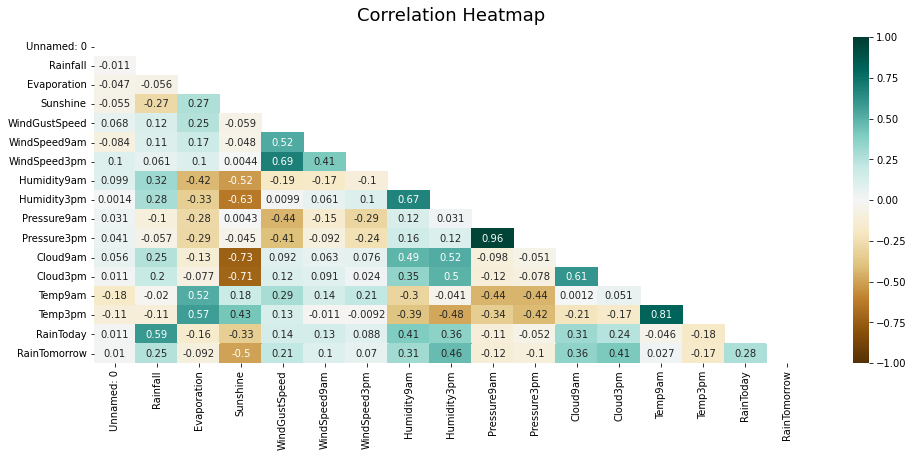

In [ ]:
plt.figure(figsize=(16, 6))

mask = np.triu(np.ones_like(data.corr(), dtype=np.bool))

heatmap = sns.heatmap(data.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

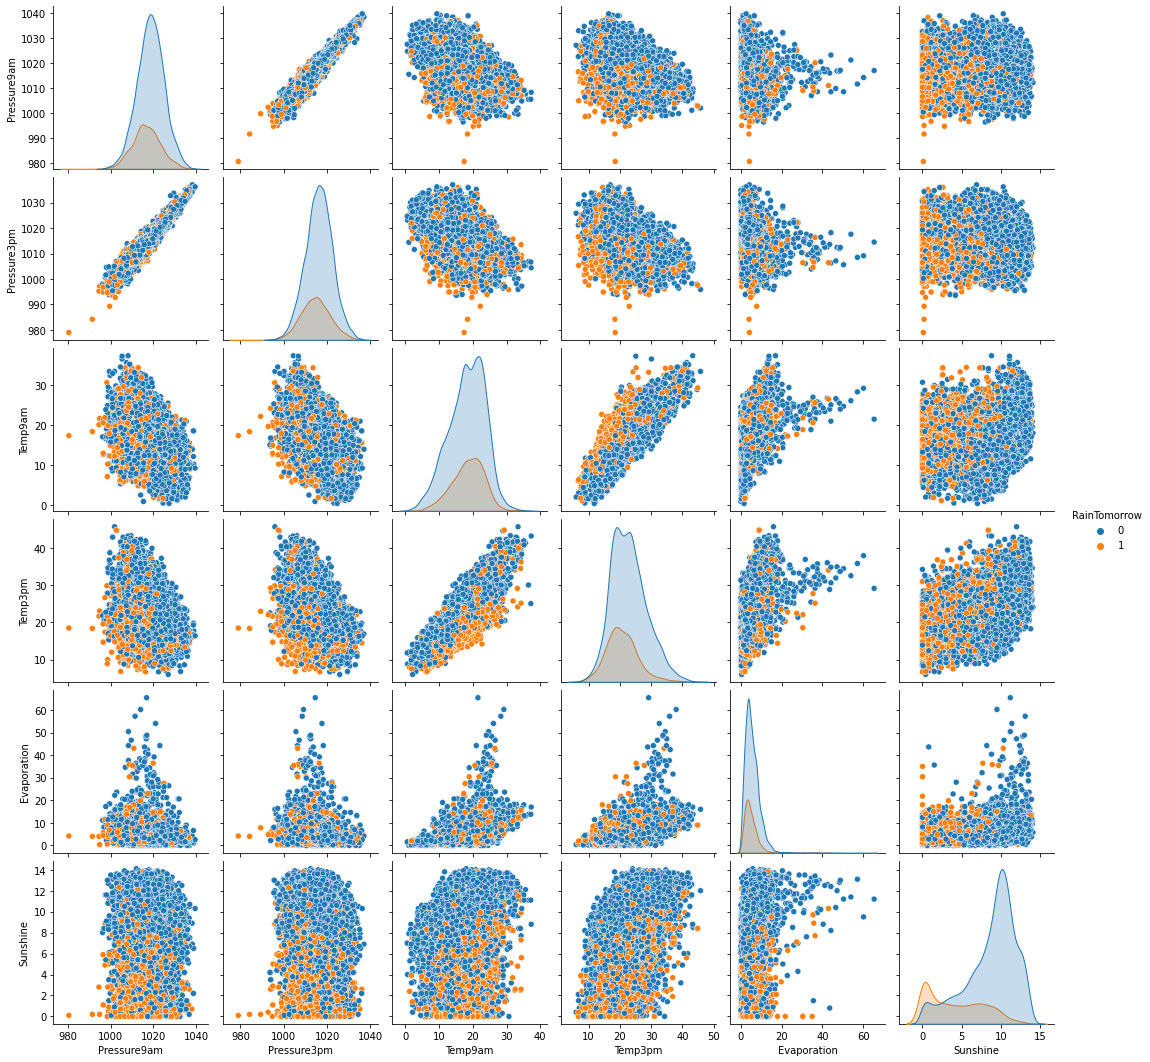

In [ ]:
sns.pairplot( data=data, vars=('Pressure9am','Pressure3pm', 'Temp9am', 'Temp3pm', 'Evaporation', 'Sunshine'), hue='RainTomorrow' )

Zdefiniujmy funkcje która będzie dziliła nam dane na biny a nastepnie dla każdego bina wyliczała prawdopodobieństwo opadu

In [ ]:
def check_probability(input_name, size=10):
  new_name = input_name + " rounded values"
  data[new_name] = data[input_name].apply(lambda x: math.ceil(x))

  g = sns.factorplot(x=new_name,y="RainTomorrow",data=data, kind="bar", size = size)
  g.despine(left=True)
  g = g.set_ylabels("rain probability")

  data.drop(labels = [new_name], axis = 1, inplace = True)

### 2.1. Date
Spróbujmy wyciągnąć z daty miesiąc, po czym zamienić go na dane kategoryczne

In [ ]:
data['Month'] = pd.DatetimeIndex(data['Date']).month.astype(str)

In [ ]:
data.head(5)

,Unnamed: 0,Date,Location,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month
0,6049,2009-01-01,Cobar,0.0,12.0,12.3,SSW,48.0,ENE,SW,...,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,0.0,0,1
1,6050,2009-01-02,Cobar,0.0,14.8,13.0,S,37.0,SSE,SSE,...,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,0.0,0,1
2,6051,2009-01-03,Cobar,0.0,10.8,10.6,NNE,46.0,NNE,NNW,...,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,0.0,0,1
3,6052,2009-01-04,Cobar,0.0,11.4,12.2,WNW,31.0,WNW,WSW,...,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,0.0,0,1
4,6053,2009-01-05,Cobar,0.0,11.2,8.4,WNW,35.0,NW,WNW,...,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,0.0,0,1


In [ ]:
data.drop(labels = ["Date"], axis = 1, inplace = True)

In [ ]:
data.columns

Index(['Unnamed: 0', 'Location', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Month'],
      dtype='object')

Sprawdźmy czy miesiąć ma wpływ na to czy następnego dnia będzie padać

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


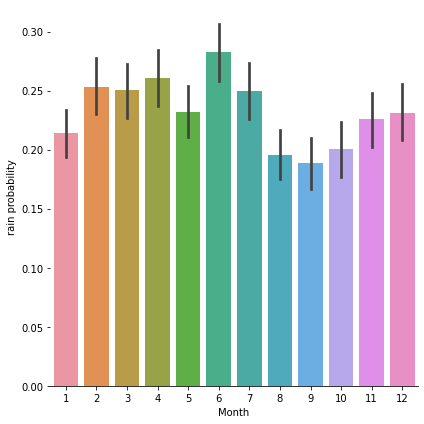

In [ ]:
g = sns.factorplot(x="Month",y="RainTomorrow",data=data, kind="bar", size = 6)
g.despine(left=True)
g = g.set_ylabels("rain probability")

Jak widać w miesiącach jesiennych możemy się liczyć z mniejszym prawdopodobieństwem opadu

### 2.2. Location

In [ ]:
data['Location'].value_counts()

SydneyAirport    2891
WaggaWagga       2529
WitchIsland      2493
Moree            1981
Sydney           1719
CoffsHarbour     1418
Williamtown      1240
Cobar             538
Name: Location, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


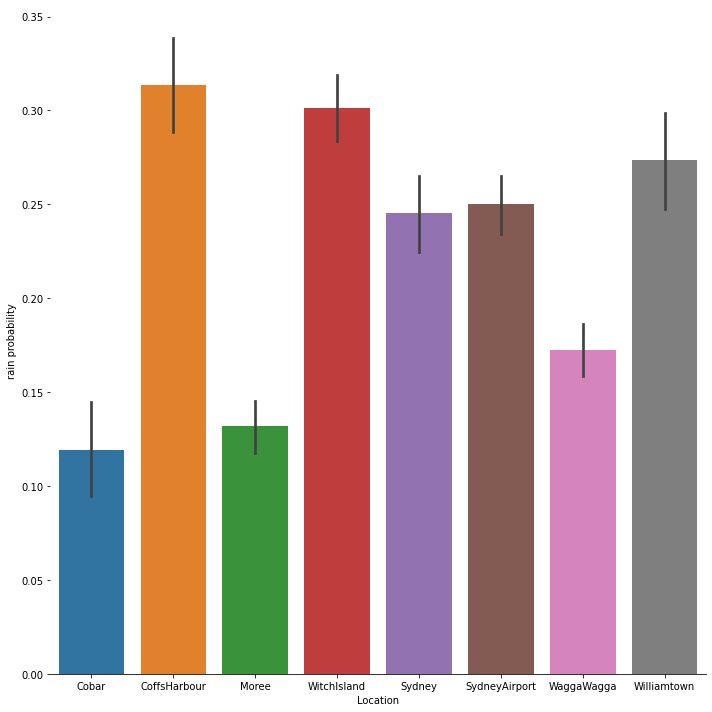

In [ ]:
g = sns.factorplot(x="Location",y="RainTomorrow",data=data, kind="bar", size = 10)
g.despine(left=True)
g = g.set_ylabels("rain probability")

Jak widać największe szanse na opad są w CoffsHarbour oraz WitchIsland

### 2.3. Rainfall i RainToday
Pomiędzy Rainfall i RainToday jest zależność polegająca na tym, że jeśli w Rainfall jest wartość większa od 1 to RainToday jest True. W przeciwnym wypadku False. Także aby nie powielać informacji usuńmy kolumne RainToday

In [ ]:
data.drop(labels = ["RainToday"], axis = 1, inplace = True)

Jak możemy dostrzec Rainfall przyjmuje jakąś wartość kiedy w RainToday mamy 1, więć aby nie powielac informacji usuiemy kolumne RainToday i uzupełnijmy Rainfall średnią

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


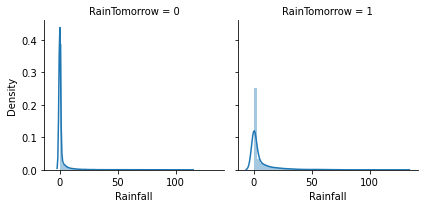

In [ ]:
g = sns.FacetGrid(data, col='RainTomorrow')
g = g.map(sns.distplot, "Rainfall")

In [ ]:
data['Rainfall'].fillna(data['Rainfall'].mean(), inplace=True)

In [ ]:
data['Rainfall'].isnull().sum()

0

### 2.4. Evaporation 

In [ ]:
data['Evaporation'].isnull().sum()

0

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


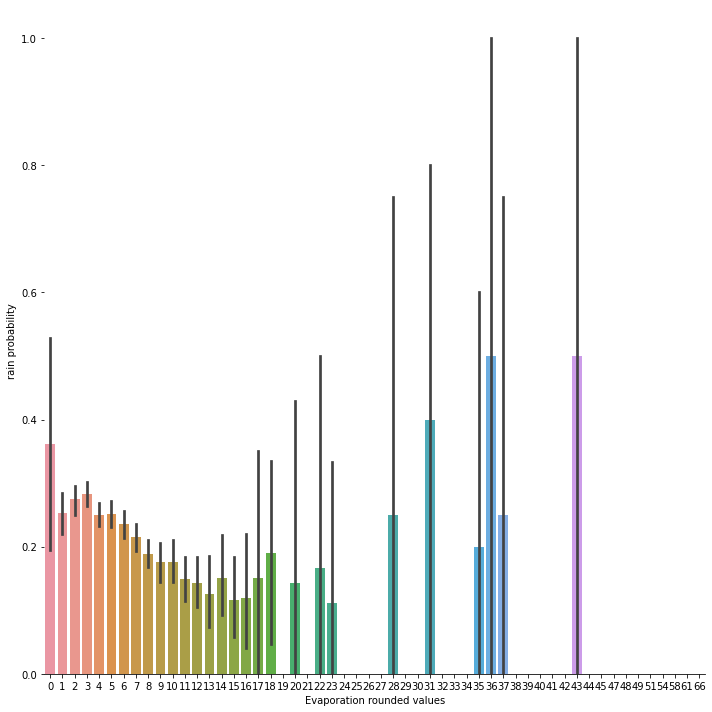

In [ ]:
check_probability("Evaporation")

Można powiedzieć, że im większe odparowanie tym mniejsza szansa na deszcz

### 2.5. Sunshine

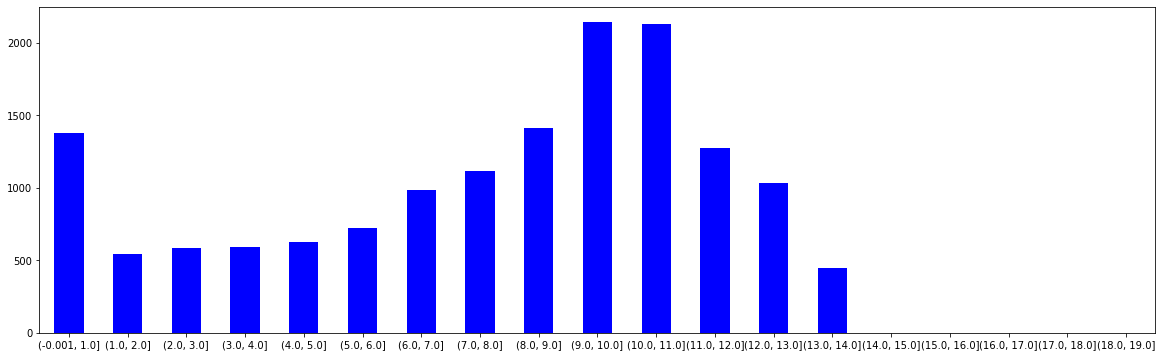

In [ ]:
out = pd.cut(data["Sunshine"], bins=[x for x in range (0, 20)], include_lowest=True)
ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(20,6))
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


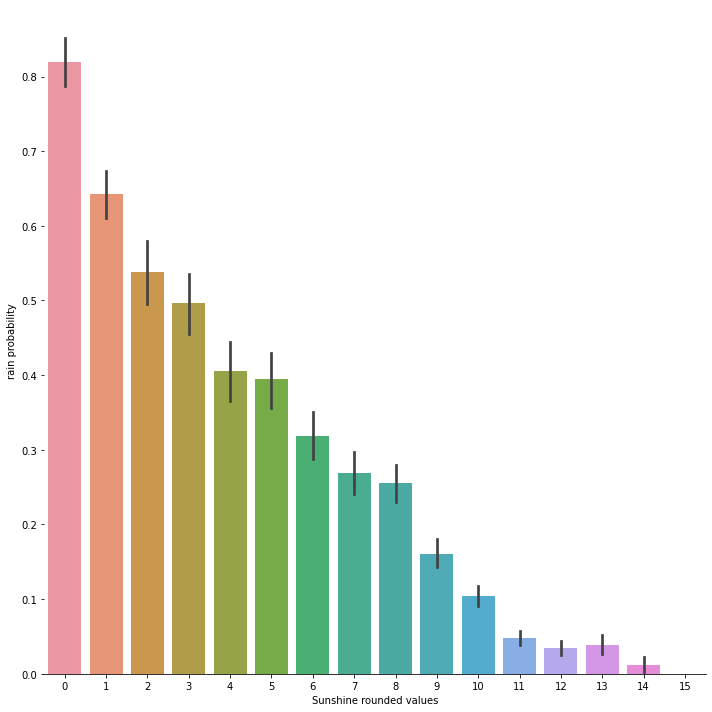

In [ ]:
check_probability("Sunshine")

Jak widać powyżej im więcej słonecznych godzin tym mniejsza szansa na deszcz jutro

In [ ]:
data['Sunshine'].isnull().sum()

0

### 2.6. WindDir
Będziemy musieli uzupełnić brakujące wartości poprzez danie w miejsce nulli najczęściej występującej wartości

In [ ]:
data['WindDir9am'].isnull().sum()

860

In [ ]:
data['WindDir9am'].value_counts()

E      1472
W      1248
WNW    1207
NW     1135
ENE    1113
NNE     844
SW      836
ESE     820
NE      808
WSW     771
N       735
SSW     718
S       680
NNW     635
SE      632
SSE     486
Name: WindDir9am, dtype: int64

In [ ]:
#data['WindDir9am'] = data['WindDir9am'].fillna(data['WindDir9am'].mode().iloc[0])

In [ ]:
data['WindDir9am'].isnull().sum()

860

In [ ]:
data['WindDir9am'].value_counts()

E      1472
W      1248
WNW    1207
NW     1135
ENE    1113
NNE     844
SW      836
ESE     820
NE      808
WSW     771
N       735
SSW     718
S       680
NNW     635
SE      632
SSE     486
Name: WindDir9am, dtype: int64

In [ ]:
#data = pd.get_dummies(data, columns = ['WindDir9am'])

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


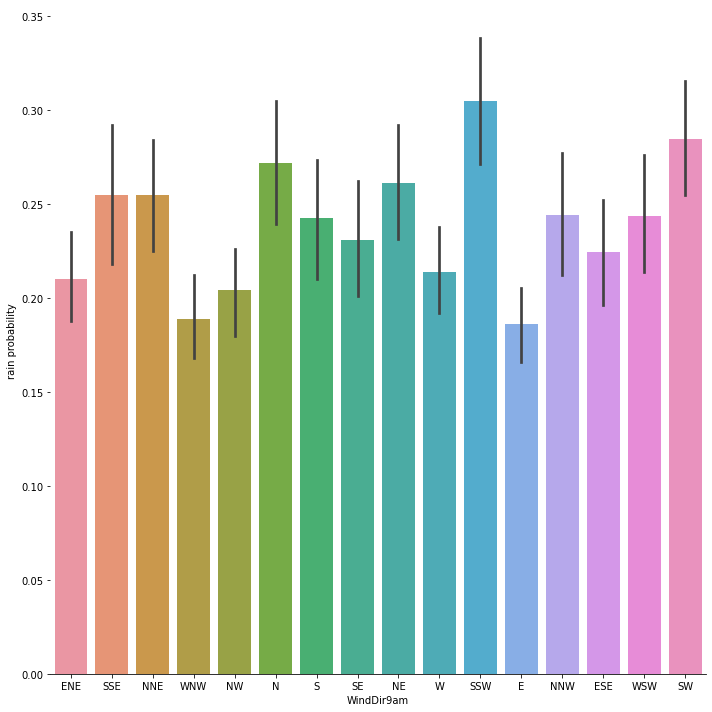

In [ ]:
g = sns.factorplot(x="WindDir9am",y="RainTomorrow",data=data, kind="bar", size = 10)
g.despine(left=True)
g = g.set_ylabels("rain probability")

Największe szanse na deszcz są przy wietrze wiejącym wkierunku SSW (południowo zachodnim, ale bardziej skierowanemu na południe). Za chwilę zobaczymy czy podobne obserwacje będą przy wietsze o godzinie 15.00

In [ ]:
data['WindDir3pm'].isnull().sum()

223

In [ ]:
data['WindDir3pm'].value_counts()

NE     1314
E      1297
SE     1206
ENE    1123
S      1116
ESE    1056
W       940
SSE     939
WSW     914
WNW     908
SW      859
SSW     792
NNE     703
NW      596
N       594
NNW     420
Name: WindDir3pm, dtype: int64

In [ ]:
#data['WindDir3pm'] = data['WindDir3pm'].fillna(data['WindDir3pm'].mode().iloc[0])

In [ ]:
data['WindDir3pm'].isnull().sum()

223

In [ ]:
#data = pd.get_dummies(data, columns = ['WindDir3pm'])

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


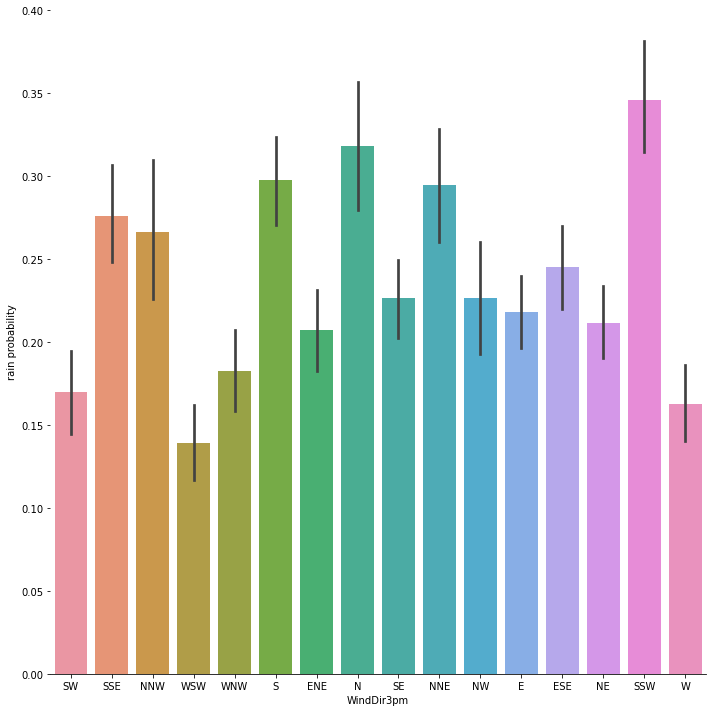

In [ ]:
g = sns.factorplot(x="WindDir3pm",y="RainTomorrow",data=data, kind="bar", size = 10)
g.despine(left=True)
g = g.set_ylabels("rain probability")

### 2.7. Unnamed: 0
Wyrzućmy tą nic nie wnoszącą kolumne

In [ ]:
data.drop(labels = ["Unnamed: 0"], axis = 1, inplace = True)

In [ ]:
data.columns

Index(['Location', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir',
       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm',
       'RainTomorrow', 'Month'],
      dtype='object')

### 2.8. WindSpeed
Zastąpmy brakujące wartości wartościami średnimi

In [ ]:
data['WindSpeed9am'].fillna(data['WindSpeed9am'].mean(), inplace=True)
data['WindSpeed3pm'].fillna(data['WindSpeed3pm'].mean(), inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


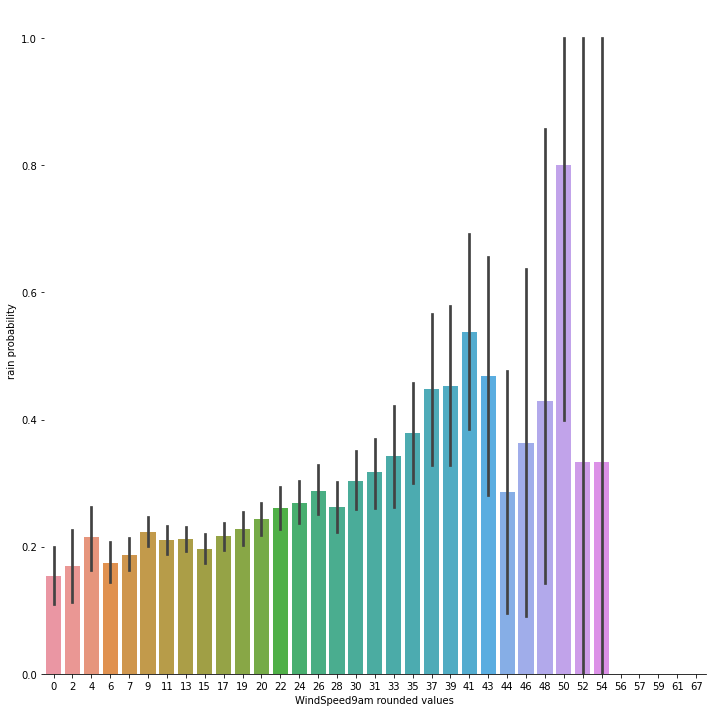

In [ ]:
check_probability("WindSpeed9am")

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


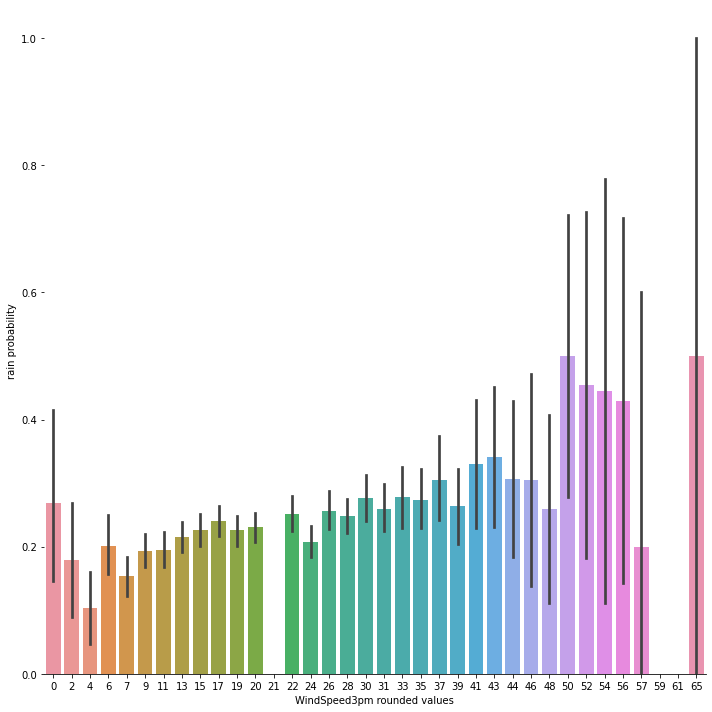

In [ ]:
check_probability("WindSpeed3pm")

Humidity9am       14
Humidity3pm       13
Pressure9am       23
Pressure3pm       16
Cloud9am           0
Cloud3pm           0

### 2.9. Humidity

In [ ]:
data['Humidity3pm'].fillna(data['Humidity3pm'].mean(), inplace=True)
data['Humidity9am'].fillna(data['Humidity9am'].mean(), inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


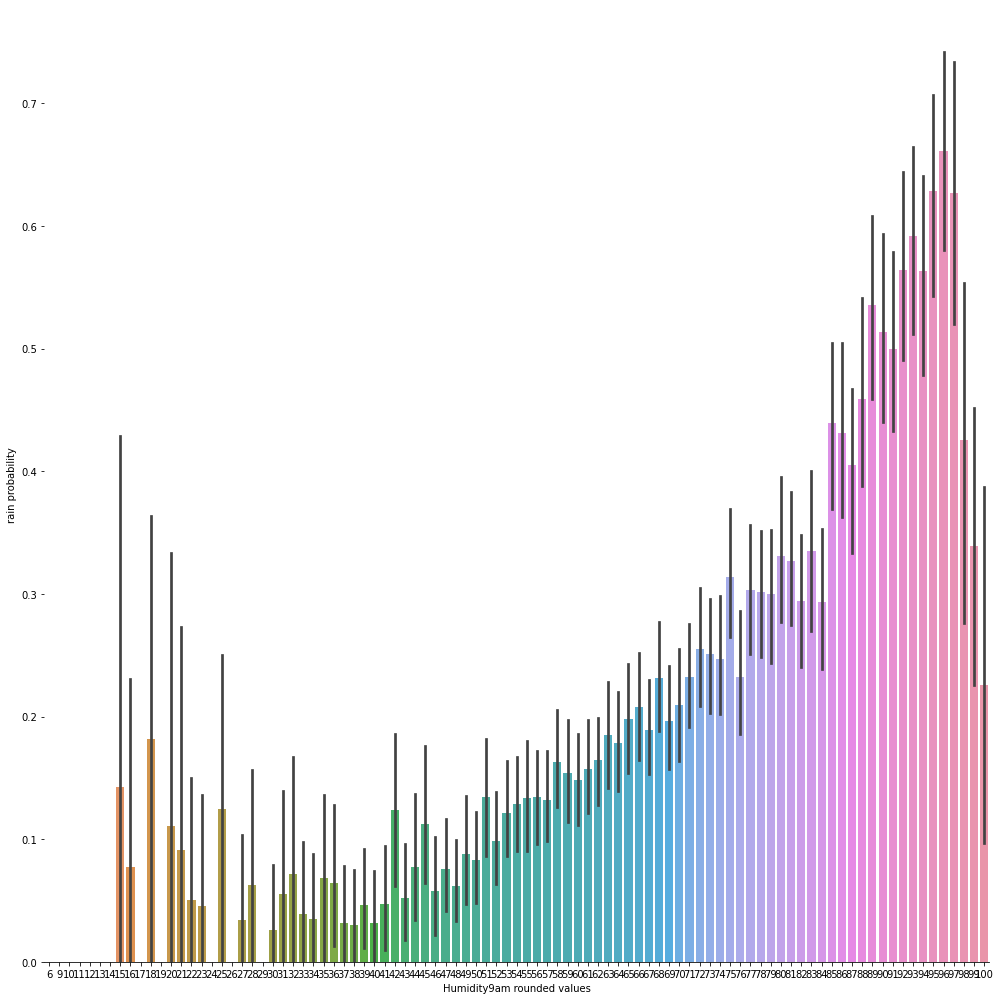

In [ ]:
check_probability("Humidity9am", 14)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


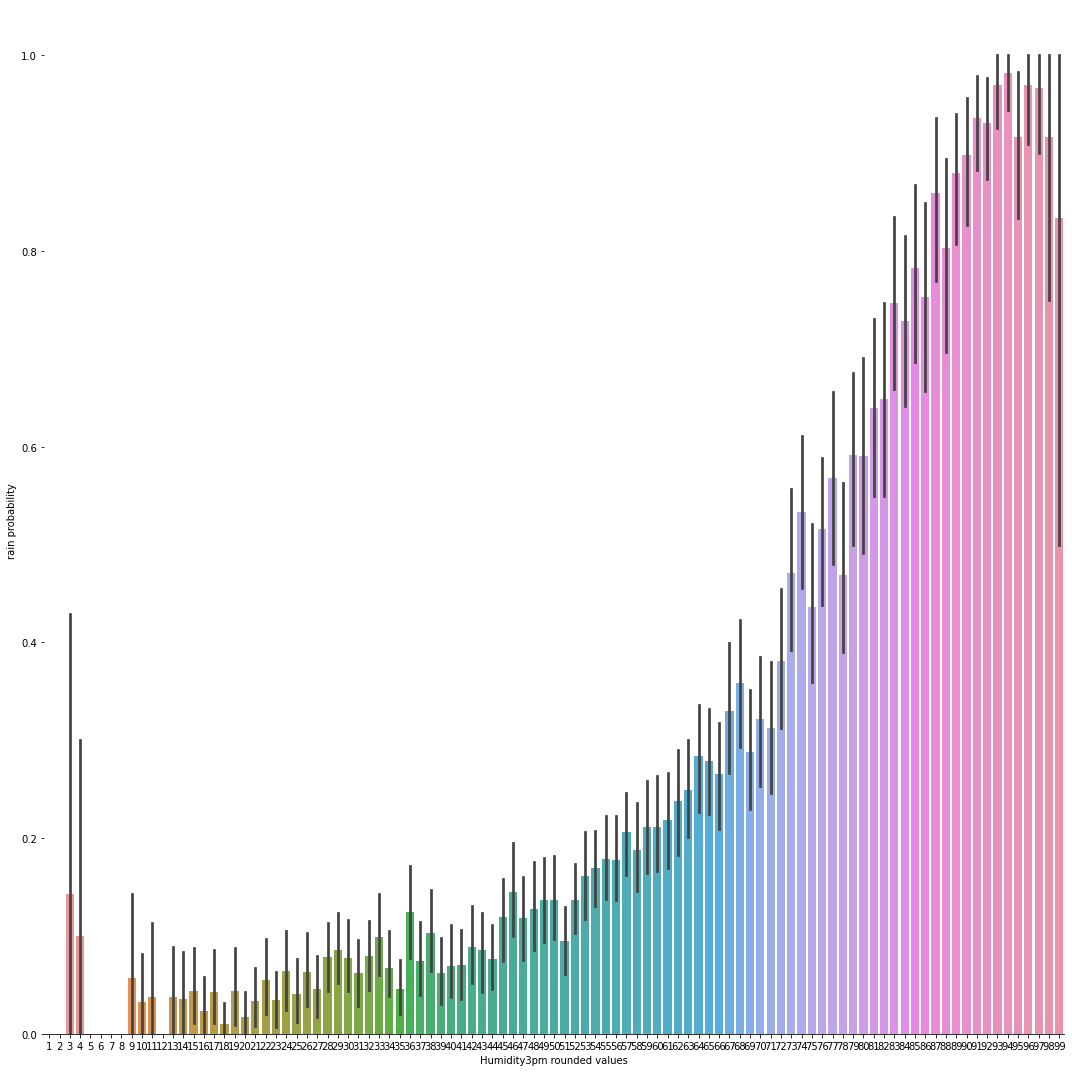

In [ ]:
check_probability("Humidity3pm", 15)

Również można dostrzec zależność, że im większa wilgotność tym większa szansa na opad

### 2.10. Pressure

In [ ]:
data['Pressure3pm'].fillna(data['Pressure3pm'].mean(), inplace=True) 
data['Pressure9am'].fillna(data['Pressure9am'].mean(), inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


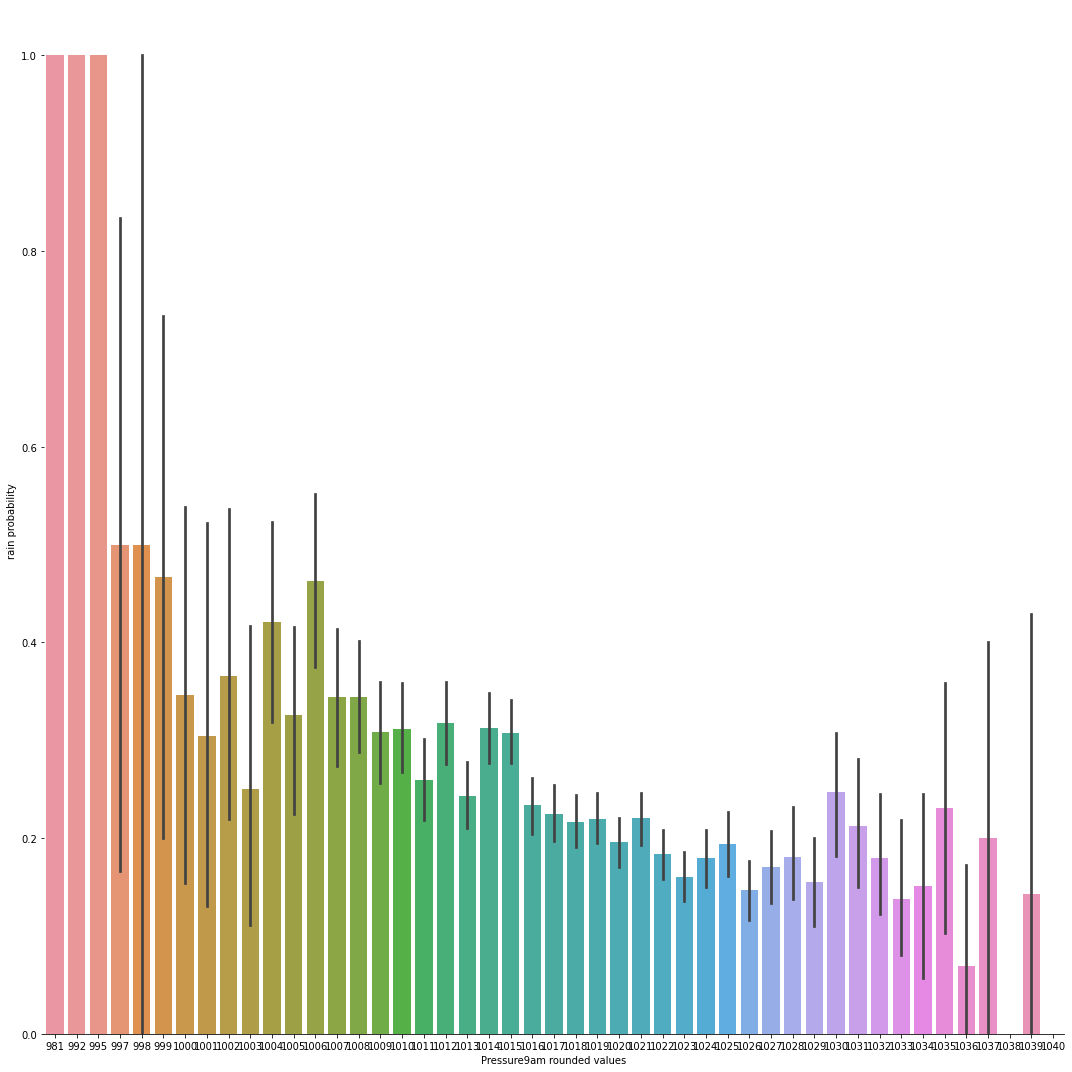

In [ ]:
check_probability('Pressure9am', 15)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


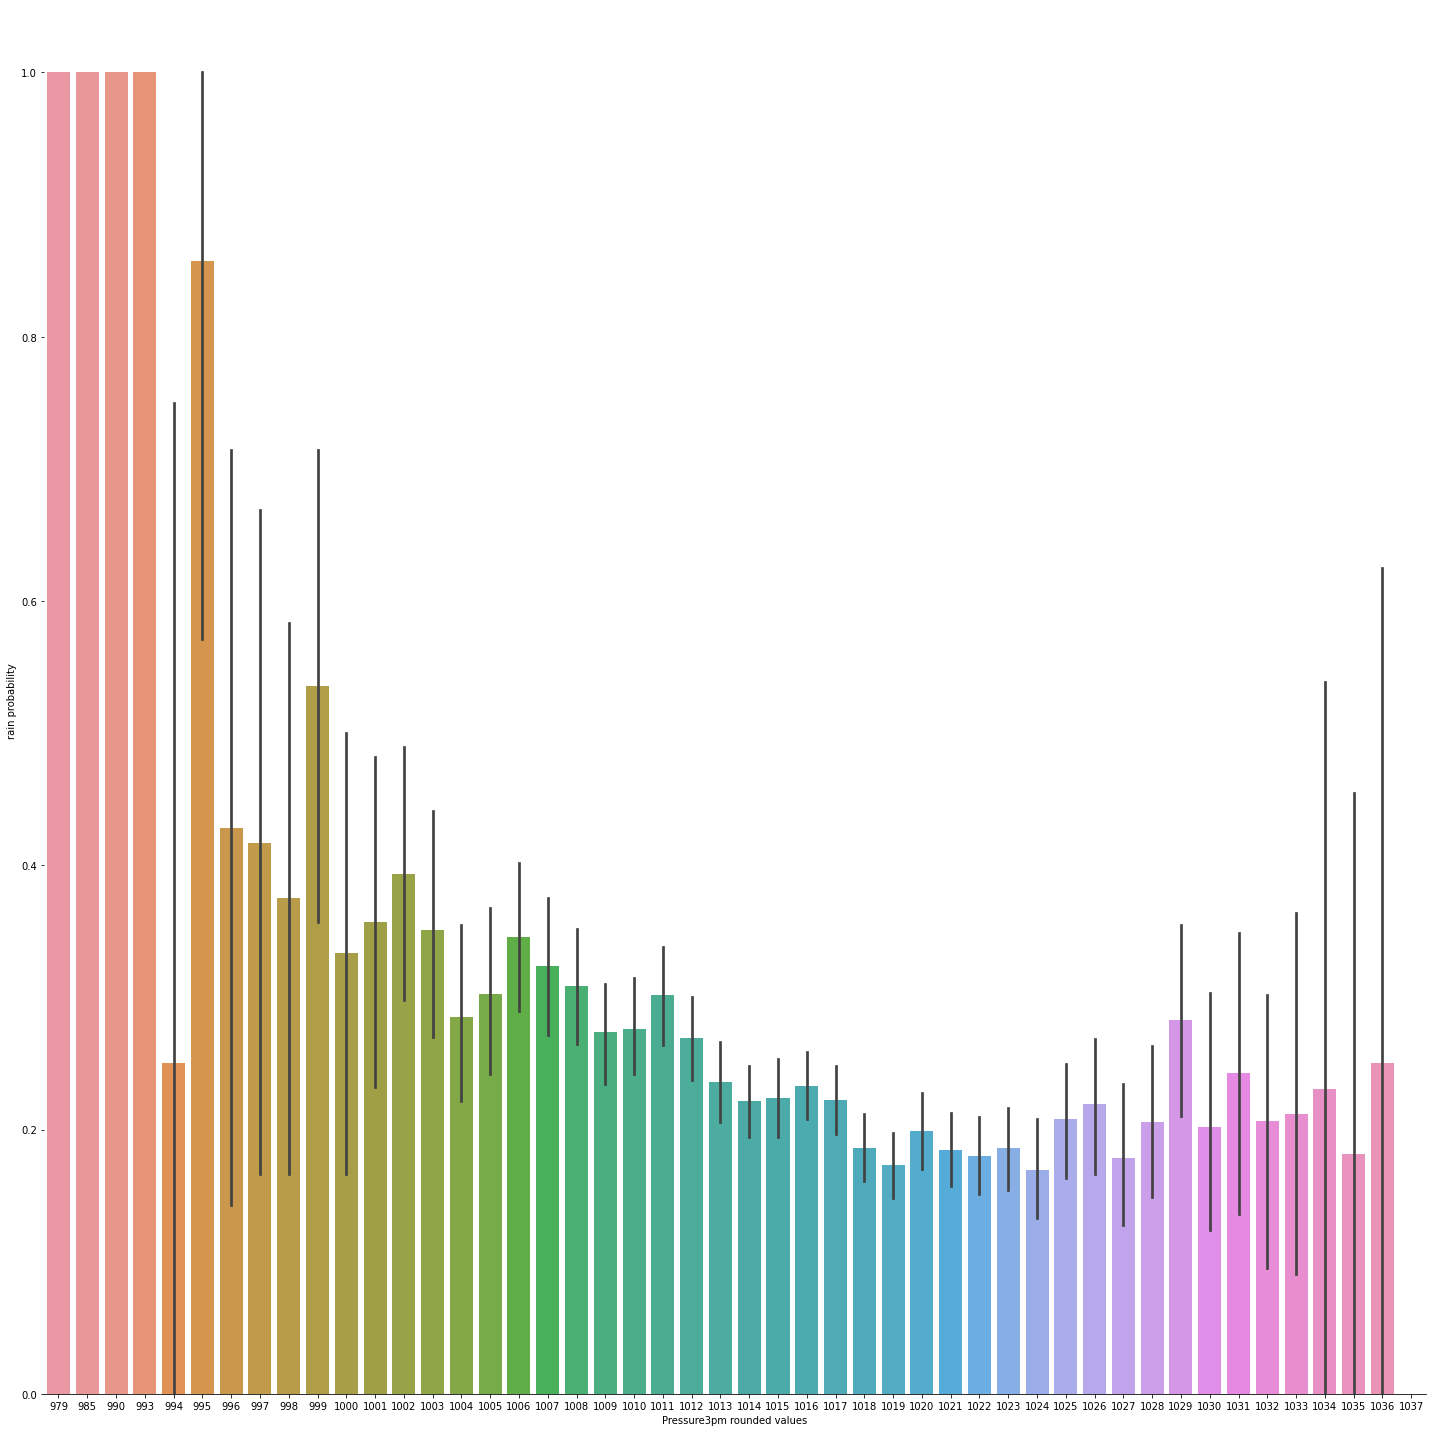

In [ ]:
check_probability('Pressure3pm', 20)

### 2.11. Cloud

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


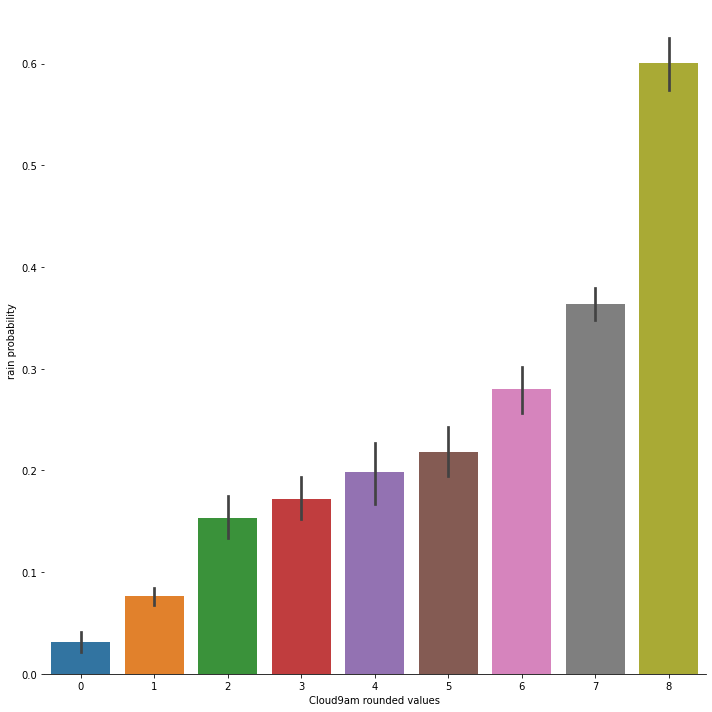

In [ ]:
check_probability("Cloud9am")

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


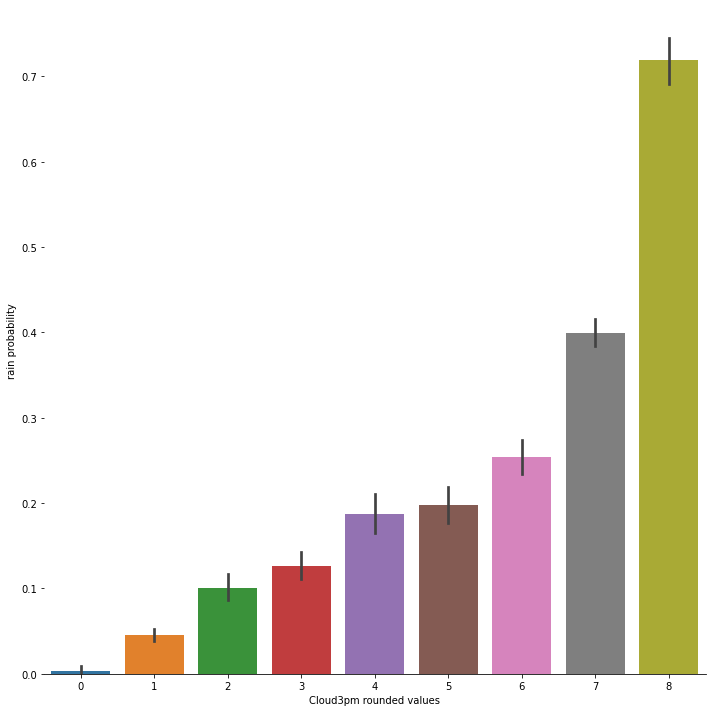

In [ ]:
check_probability("Cloud3pm")

W obu przypadkach możemy dojśc do wniosku, że im większa część nieba jest przysłonięta chmurami to tym większe prawdopodobieństwo opadów

## 3 Pipeline'y

In [ ]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

Pipeline dla numerycznych



In [ ]:
numerical_fields = ["Evaporation", "Rainfall", "Sunshine", "WindGustSpeed", 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(numerical_fields)),
        ("imputer", SimpleImputer(strategy="median")),
    ])


Pipeline dla kategorycznych

In [ ]:
catbin = ["Location","WindGustDir" ,"WindDir9am", "WindDir3pm", "Month"]

cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(catbin)),
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse=False, handle_unknown = 'ignore')),
    ])

In [ ]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

## 4 Podział danych na train i test

In [ ]:
y = data["RainTomorrow"]
X = data.drop("RainTomorrow", axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
num_pipeline.fit_transform(X_train)

array([[12.6,  0. , 13. , ...,  1. , 25.7, 29.9],
       [ 4. ,  0. ,  2.5, ...,  7. , 16.9, 18.2],
       [ 5.4,  0. ,  7.7, ...,  5. , 15.3, 19.7],
       ...,
       [ 4.4,  0. , 10.4, ...,  1. , 20.5, 21. ],
       [ 5.2,  0. , 12.9, ...,  1. , 26.6, 27.7],
       [ 8. ,  0. ,  8.4, ...,  4. , 23.8, 24.6]])

In [ ]:
cat_pipeline.fit_transform(X_train)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
seed=123
kfold = StratifiedKFold(n_splits=10)

# 5 Uczenie modeli

## 5.1 Uczenie płytkie

### 5.1.1 Decision Tree

In [ ]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', DecisionTreeClassifier())])

dt_param_grid = {
    'classifier__max_depth': range(2, 10),
    'classifier__max_features': range(2, 14),
    }

gsDT = GridSearchCV(pipe, dt_param_grid, cv=kfold, verbose=10)
gsDT.fit(X_train,y_train)
DT_best = gsDT.best_estimator_

Fitting 10 folds for each of 96 candidates, totalling 960 fits
[CV 1/10; 1/96] START classifier__max_depth=2, classifier__max_features=2.......
[CV 1/10; 1/96] END classifier__max_depth=2, classifier__max_features=2;, score=0.832 total time=   0.1s
[CV 2/10; 1/96] START classifier__max_depth=2, classifier__max_features=2.......
[CV 2/10; 1/96] END classifier__max_depth=2, classifier__max_features=2;, score=0.767 total time=   0.1s
[CV 3/10; 1/96] START classifier__max_depth=2, classifier__max_features=2.......
[CV 3/10; 1/96] END classifier__max_depth=2, classifier__max_features=2;, score=0.767 total time=   0.1s
[CV 4/10; 1/96] START classifier__max_depth=2, classifier__max_features=2.......
[CV 4/10; 1/96] END classifier__max_depth=2, classifier__max_features=2;, score=0.767 total time=   0.1s
[CV 5/10; 1/96] START classifier__max_depth=2, classifier__max_features=2.......
[CV 5/10; 1/96] END classifier__max_depth=2, classifier__max_features=2;, score=0.767 total time=   0.1s
[CV 6/1

### 5.1.2 Random Forest Classifier

In [ ]:
# Random Forest Classifier

pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', RandomForestClassifier())])



rf_param_grid = { 
    'classifier__n_estimators': [100, 300],
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__max_depth': [3,5,7,9],
    'classifier__criterion': ['gini']
}

gsRFC = GridSearchCV(pipe, rf_param_grid, cv=kfold, verbose=10)
gsRFC.fit(X_train,y_train)
RFC_best = gsRFC.best_estimator_

print(gsRFC.best_score_)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
[CV 1/10; 1/24] START classifier__criterion=gini, classifier__max_depth=3, classifier__max_features=auto, classifier__n_estimators=100
[CV 1/10; 1/24] END classifier__criterion=gini, classifier__max_depth=3, classifier__max_features=auto, classifier__n_estimators=100;, score=0.821 total time=   0.7s
[CV 2/10; 1/24] START classifier__criterion=gini, classifier__max_depth=3, classifier__max_features=auto, classifier__n_estimators=100
[CV 2/10; 1/24] END classifier__criterion=gini, classifier__max_depth=3, classifier__max_features=auto, classifier__n_estimators=100;, score=0.820 total time=   0.7s
[CV 3/10; 1/24] START classifier__criterion=gini, classifier__max_depth=3, classifier__max_features=auto, classifier__n_estimators=100
[CV 3/10; 1/24] END classifier__criterion=gini, classifier__max_depth=3, classifier__max_features=auto, classifier__n_estimators=100;, score=0.826 total time=   0.7s
[CV 4/10; 1/24] START classifier__

### 5.1.3 Gradient Boosting

In [ ]:
# Gradient boosting tunning

pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', GradientBoostingClassifier())])


gb_param_grid = {'classifier__loss' : ["deviance"],
              'classifier__n_estimators' : [100,200],
              'classifier__learning_rate': [0.05, 0.1],
              'classifier__max_depth': [4, 8, 12],
              'classifier__max_features': [0.5, 0.3, 0.1] 
              }

gsGBC = GridSearchCV(pipe, gb_param_grid, cv=kfold, verbose=10)

gsGBC.fit(X_train,y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV 1/10; 1/36] START classifier__learning_rate=0.05, classifier__loss=deviance, classifier__max_depth=4, classifier__max_features=0.5, classifier__n_estimators=100
[CV 1/10; 1/36] END classifier__learning_rate=0.05, classifier__loss=deviance, classifier__max_depth=4, classifier__max_features=0.5, classifier__n_estimators=100;, score=0.849 total time=   4.9s
[CV 2/10; 1/36] START classifier__learning_rate=0.05, classifier__loss=deviance, classifier__max_depth=4, classifier__max_features=0.5, classifier__n_estimators=100
[CV 2/10; 1/36] END classifier__learning_rate=0.05, classifier__loss=deviance, classifier__max_depth=4, classifier__max_features=0.5, classifier__n_estimators=100;, score=0.841 total time=   3.6s
[CV 3/10; 1/36] START classifier__learning_rate=0.05, classifier__loss=deviance, classifier__max_depth=4, classifier__max_features=0.5, classifier__n_estimators=100
[CV 3/10; 1/36] END classifier__learning_rate=0.05

0.8549166666666667

### 5.1.4 Logistic Regression

In [ ]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', LogisticRegression())])

LR_param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
     'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}


gsLR = GridSearchCV(pipe ,param_grid = LR_param_grid, cv=kfold, verbose = 10)

gsLR.fit(X_train,y_train)

LR_best = gsLR.best_estimator_

gsLR.best_score_

Fitting 10 folds for each of 35 candidates, totalling 350 fits
[CV 1/10; 1/35] START classifier__C=0.001, classifier__solver=newton-cg.........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV 1/10; 1/35] END classifier__C=0.001, classifier__solver=newton-cg;, score=0.843 total time=   3.1s
[CV 2/10; 1/35] START classifier__C=0.001, classifier__solver=newton-cg.........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV 2/10; 1/35] END classifier__C=0.001, classifier__solver=newton-cg;, score=0.835 total time=   2.7s
[CV 3/10; 1/35] START classifier__C=0.001, classifier__solver=newton-cg.........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV 3/10; 1/35] END classifier__C=0.001, classifier__solver=newton-cg;, score=0.850 total time=   3.5s
[CV 4/10; 1/35] START classifier__C=0.001, classifier__solver=newton-cg.........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV 4/10; 1/35] END classifier__C=0.001, classifier__solver=newton-cg;, score=0.853 total time=   3.3s
[CV 5/10; 1/35] START classifier__C=0.001, classifier__solver=newton-cg.........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV 5/10; 1/35] END classifier__C=0.001, classifier__solver=newton-cg;, score=0.845 total time=   2.6s
[CV 6/10; 1/35] START classifier__C=0.001, classifier__solver=newton-cg.........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV 6/10; 1/35] END classifier__C=0.001, classifier__solver=newton-cg;, score=0.851 total time=   3.0s
[CV 7/10; 1/35] START classifier__C=0.001, classifier__solver=newton-cg.........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV 7/10; 1/35] END classifier__C=0.001, classifier__solver=newton-cg;, score=0.843 total time=   3.0s
[CV 8/10; 1/35] START classifier__C=0.001, classifier__solver=newton-cg.........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 8/10; 1/35] END classifier__C=0.001, classifier__solver=newton-cg;, score=0.852 total time=   2.0s
[CV 9/10; 1/35] START classifier__C=0.001, classifier__solver=newton-cg.........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV 9/10; 1/35] END classifier__C=0.001, classifier__solver=newton-cg;, score=0.852 total time=   2.8s
[CV 10/10; 1/35] START classifier__C=0.001, classifier__solver=newton-cg........
[CV 10/10; 1/35] END classifier__C=0.001, classifier__solver=newton-cg;, score=0.843 total time=   2.2s
[CV 1/10; 2/35] START classifier__C=0.001, classifier__solver=lbfgs.............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10; 2/35] END classifier__C=0.001, classifier__solver=lbfgs;, score=0.847 total time=   0.4s
[CV 2/10; 2/35] START classifier__C=0.001, classifier__solver=lbfgs.............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10; 2/35] END classifier__C=0.001, classifier__solver=lbfgs;, score=0.838 total time=   0.4s
[CV 3/10; 2/35] START classifier__C=0.001, classifier__solver=lbfgs.............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10; 2/35] END classifier__C=0.001, classifier__solver=lbfgs;, score=0.850 total time=   0.5s
[CV 4/10; 2/35] START classifier__C=0.001, classifier__solver=lbfgs.............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10; 2/35] END classifier__C=0.001, classifier__solver=lbfgs;, score=0.850 total time=   0.4s
[CV 5/10; 2/35] START classifier__C=0.001, classifier__solver=lbfgs.............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10; 2/35] END classifier__C=0.001, classifier__solver=lbfgs;, score=0.848 total time=   0.4s
[CV 6/10; 2/35] START classifier__C=0.001, classifier__solver=lbfgs.............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10; 2/35] END classifier__C=0.001, classifier__solver=lbfgs;, score=0.852 total time=   0.5s
[CV 7/10; 2/35] START classifier__C=0.001, classifier__solver=lbfgs.............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10; 2/35] END classifier__C=0.001, classifier__solver=lbfgs;, score=0.840 total time=   0.5s
[CV 8/10; 2/35] START classifier__C=0.001, classifier__solver=lbfgs.............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10; 2/35] END classifier__C=0.001, classifier__solver=lbfgs;, score=0.850 total time=   0.5s
[CV 9/10; 2/35] START classifier__C=0.001, classifier__solver=lbfgs.............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10; 2/35] END classifier__C=0.001, classifier__solver=lbfgs;, score=0.853 total time=   0.4s
[CV 10/10; 2/35] START classifier__C=0.001, classifier__solver=lbfgs............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10; 2/35] END classifier__C=0.001, classifier__solver=lbfgs;, score=0.848 total time=   0.4s
[CV 1/10; 3/35] START classifier__C=0.001, classifier__solver=liblinear.........
[CV 1/10; 3/35] END classifier__C=0.001, classifier__solver=liblinear;, score=0.846 total time=   0.2s
[CV 2/10; 3/35] START classifier__C=0.001, classifier__solver=liblinear.........
[CV 2/10; 3/35] END classifier__C=0.001, classifier__solver=liblinear;, score=0.838 total time=   0.2s
[CV 3/10; 3/35] START classifier__C=0.001, classifier__solver=liblinear.........
[CV 3/10; 3/35] END classifier__C=0.001, classifier__solver=liblinear;, score=0.853 total time=   0.2s
[CV 4/10; 3/35] START classifier__C=0.001, classifier__solver=liblinear.........
[CV 4/10; 3/35] END classifier__C=0.001, classifier__solver=liblinear;, score=0.853 total time=   0.2s
[CV 5/10; 3/35] START classifier__C=0.001, classifier__solver=liblinear.........
[CV 5/10; 3/35] END classifier__C=0.001, classifier__solver=liblinear;, score=0.844

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10; 4/35] END classifier__C=0.001, classifier__solver=sag;, score=0.848 total time=   1.4s
[CV 2/10; 4/35] START classifier__C=0.001, classifier__solver=sag...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10; 4/35] END classifier__C=0.001, classifier__solver=sag;, score=0.837 total time=   1.4s
[CV 3/10; 4/35] START classifier__C=0.001, classifier__solver=sag...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10; 4/35] END classifier__C=0.001, classifier__solver=sag;, score=0.853 total time=   2.3s
[CV 4/10; 4/35] START classifier__C=0.001, classifier__solver=sag...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10; 4/35] END classifier__C=0.001, classifier__solver=sag;, score=0.849 total time=   1.4s
[CV 5/10; 4/35] START classifier__C=0.001, classifier__solver=sag...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10; 4/35] END classifier__C=0.001, classifier__solver=sag;, score=0.847 total time=   1.4s
[CV 6/10; 4/35] START classifier__C=0.001, classifier__solver=sag...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10; 4/35] END classifier__C=0.001, classifier__solver=sag;, score=0.850 total time=   1.4s
[CV 7/10; 4/35] START classifier__C=0.001, classifier__solver=sag...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10; 4/35] END classifier__C=0.001, classifier__solver=sag;, score=0.843 total time=   1.5s
[CV 8/10; 4/35] START classifier__C=0.001, classifier__solver=sag...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10; 4/35] END classifier__C=0.001, classifier__solver=sag;, score=0.850 total time=   1.4s
[CV 9/10; 4/35] START classifier__C=0.001, classifier__solver=sag...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10; 4/35] END classifier__C=0.001, classifier__solver=sag;, score=0.854 total time=   1.4s
[CV 10/10; 4/35] START classifier__C=0.001, classifier__solver=sag..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10; 4/35] END classifier__C=0.001, classifier__solver=sag;, score=0.847 total time=   1.4s
[CV 1/10; 5/35] START classifier__C=0.001, classifier__solver=saga..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10; 5/35] END classifier__C=0.001, classifier__solver=saga;, score=0.851 total time=   1.6s
[CV 2/10; 5/35] START classifier__C=0.001, classifier__solver=saga..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10; 5/35] END classifier__C=0.001, classifier__solver=saga;, score=0.837 total time=   1.6s
[CV 3/10; 5/35] START classifier__C=0.001, classifier__solver=saga..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10; 5/35] END classifier__C=0.001, classifier__solver=saga;, score=0.847 total time=   1.6s
[CV 4/10; 5/35] START classifier__C=0.001, classifier__solver=saga..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10; 5/35] END classifier__C=0.001, classifier__solver=saga;, score=0.848 total time=   1.6s
[CV 5/10; 5/35] START classifier__C=0.001, classifier__solver=saga..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10; 5/35] END classifier__C=0.001, classifier__solver=saga;, score=0.846 total time=   1.6s
[CV 6/10; 5/35] START classifier__C=0.001, classifier__solver=saga..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10; 5/35] END classifier__C=0.001, classifier__solver=saga;, score=0.847 total time=   1.6s
[CV 7/10; 5/35] START classifier__C=0.001, classifier__solver=saga..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10; 5/35] END classifier__C=0.001, classifier__solver=saga;, score=0.843 total time=   1.6s
[CV 8/10; 5/35] START classifier__C=0.001, classifier__solver=saga..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10; 5/35] END classifier__C=0.001, classifier__solver=saga;, score=0.851 total time=   1.6s
[CV 9/10; 5/35] START classifier__C=0.001, classifier__solver=saga..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10; 5/35] END classifier__C=0.001, classifier__solver=saga;, score=0.858 total time=   1.6s
[CV 10/10; 5/35] START classifier__C=0.001, classifier__solver=saga.............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10; 5/35] END classifier__C=0.001, classifier__solver=saga;, score=0.847 total time=   1.6s
[CV 1/10; 6/35] START classifier__C=0.01, classifier__solver=newton-cg..........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:426: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWa

[CV 1/10; 6/35] END classifier__C=0.01, classifier__solver=newton-cg;, score=0.846 total time=   3.0s
[CV 2/10; 6/35] START classifier__C=0.01, classifier__solver=newton-cg..........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/10; 6/35] END classifier__C=0.01, classifier__solver=newton-cg;, score=0.840 total time=   3.0s
[CV 3/10; 6/35] START classifier__C=0.01, classifier__solver=newton-cg..........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/10; 6/35] END classifier__C=0.01, classifier__solver=newton-cg;, score=0.858 total time=   2.8s
[CV 4/10; 6/35] START classifier__C=0.01, classifier__solver=newton-cg..........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/10; 6/35] END classifier__C=0.01, classifier__solver=newton-cg;, score=0.859 total time=   2.7s
[CV 5/10; 6/35] START classifier__C=0.01, classifier__solver=newton-cg..........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 5/10; 6/35] END classifier__C=0.01, classifier__solver=newton-cg;, score=0.851 total time=   2.8s
[CV 6/10; 6/35] START classifier__C=0.01, classifier__solver=newton-cg..........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV 6/10; 6/35] END classifier__C=0.01, classifier__solver=newton-cg;, score=0.852 total time=   3.2s
[CV 7/10; 6/35] START classifier__C=0.01, classifier__solver=newton-cg..........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 7/10; 6/35] END classifier__C=0.01, classifier__solver=newton-cg;, score=0.846 total time=   3.3s
[CV 8/10; 6/35] START classifier__C=0.01, classifier__solver=newton-cg..........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV 8/10; 6/35] END classifier__C=0.01, classifier__solver=newton-cg;, score=0.853 total time=   3.3s
[CV 9/10; 6/35] START classifier__C=0.01, classifier__solver=newton-cg..........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV 9/10; 6/35] END classifier__C=0.01, classifier__solver=newton-cg;, score=0.853 total time=   3.3s
[CV 10/10; 6/35] START classifier__C=0.01, classifier__solver=newton-cg.........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV 10/10; 6/35] END classifier__C=0.01, classifier__solver=newton-cg;, score=0.842 total time=   3.4s
[CV 1/10; 7/35] START classifier__C=0.01, classifier__solver=lbfgs..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10; 7/35] END classifier__C=0.01, classifier__solver=lbfgs;, score=0.843 total time=   0.5s
[CV 2/10; 7/35] START classifier__C=0.01, classifier__solver=lbfgs..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10; 7/35] END classifier__C=0.01, classifier__solver=lbfgs;, score=0.841 total time=   0.4s
[CV 3/10; 7/35] START classifier__C=0.01, classifier__solver=lbfgs..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10; 7/35] END classifier__C=0.01, classifier__solver=lbfgs;, score=0.852 total time=   0.4s
[CV 4/10; 7/35] START classifier__C=0.01, classifier__solver=lbfgs..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10; 7/35] END classifier__C=0.01, classifier__solver=lbfgs;, score=0.848 total time=   0.5s
[CV 5/10; 7/35] START classifier__C=0.01, classifier__solver=lbfgs..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10; 7/35] END classifier__C=0.01, classifier__solver=lbfgs;, score=0.844 total time=   0.4s
[CV 6/10; 7/35] START classifier__C=0.01, classifier__solver=lbfgs..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10; 7/35] END classifier__C=0.01, classifier__solver=lbfgs;, score=0.846 total time=   0.5s
[CV 7/10; 7/35] START classifier__C=0.01, classifier__solver=lbfgs..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10; 7/35] END classifier__C=0.01, classifier__solver=lbfgs;, score=0.840 total time=   0.4s
[CV 8/10; 7/35] START classifier__C=0.01, classifier__solver=lbfgs..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10; 7/35] END classifier__C=0.01, classifier__solver=lbfgs;, score=0.853 total time=   0.5s
[CV 9/10; 7/35] START classifier__C=0.01, classifier__solver=lbfgs..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10; 7/35] END classifier__C=0.01, classifier__solver=lbfgs;, score=0.853 total time=   0.5s
[CV 10/10; 7/35] START classifier__C=0.01, classifier__solver=lbfgs.............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10; 7/35] END classifier__C=0.01, classifier__solver=lbfgs;, score=0.844 total time=   0.5s
[CV 1/10; 8/35] START classifier__C=0.01, classifier__solver=liblinear..........
[CV 1/10; 8/35] END classifier__C=0.01, classifier__solver=liblinear;, score=0.848 total time=   0.2s
[CV 2/10; 8/35] START classifier__C=0.01, classifier__solver=liblinear..........
[CV 2/10; 8/35] END classifier__C=0.01, classifier__solver=liblinear;, score=0.839 total time=   0.2s
[CV 3/10; 8/35] START classifier__C=0.01, classifier__solver=liblinear..........
[CV 3/10; 8/35] END classifier__C=0.01, classifier__solver=liblinear;, score=0.856 total time=   0.2s
[CV 4/10; 8/35] START classifier__C=0.01, classifier__solver=liblinear..........
[CV 4/10; 8/35] END classifier__C=0.01, classifier__solver=liblinear;, score=0.860 total time=   0.2s
[CV 5/10; 8/35] START classifier__C=0.01, classifier__solver=liblinear..........
[CV 5/10; 8/35] END classifier__C=0.01, classifier__solver=liblinear;, score=0.849 total

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10; 9/35] END classifier__C=0.01, classifier__solver=sag;, score=0.848 total time=   1.3s
[CV 2/10; 9/35] START classifier__C=0.01, classifier__solver=sag................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10; 9/35] END classifier__C=0.01, classifier__solver=sag;, score=0.838 total time=   1.4s
[CV 3/10; 9/35] START classifier__C=0.01, classifier__solver=sag................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10; 9/35] END classifier__C=0.01, classifier__solver=sag;, score=0.853 total time=   1.3s
[CV 4/10; 9/35] START classifier__C=0.01, classifier__solver=sag................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10; 9/35] END classifier__C=0.01, classifier__solver=sag;, score=0.850 total time=   1.4s
[CV 5/10; 9/35] START classifier__C=0.01, classifier__solver=sag................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10; 9/35] END classifier__C=0.01, classifier__solver=sag;, score=0.845 total time=   1.3s
[CV 6/10; 9/35] START classifier__C=0.01, classifier__solver=sag................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10; 9/35] END classifier__C=0.01, classifier__solver=sag;, score=0.851 total time=   1.3s
[CV 7/10; 9/35] START classifier__C=0.01, classifier__solver=sag................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10; 9/35] END classifier__C=0.01, classifier__solver=sag;, score=0.840 total time=   1.4s
[CV 8/10; 9/35] START classifier__C=0.01, classifier__solver=sag................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10; 9/35] END classifier__C=0.01, classifier__solver=sag;, score=0.851 total time=   1.4s
[CV 9/10; 9/35] START classifier__C=0.01, classifier__solver=sag................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10; 9/35] END classifier__C=0.01, classifier__solver=sag;, score=0.853 total time=   1.3s
[CV 10/10; 9/35] START classifier__C=0.01, classifier__solver=sag...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10; 9/35] END classifier__C=0.01, classifier__solver=sag;, score=0.848 total time=   1.4s
[CV 1/10; 10/35] START classifier__C=0.01, classifier__solver=saga..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10; 10/35] END classifier__C=0.01, classifier__solver=saga;, score=0.851 total time=   1.6s
[CV 2/10; 10/35] START classifier__C=0.01, classifier__solver=saga..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10; 10/35] END classifier__C=0.01, classifier__solver=saga;, score=0.836 total time=   1.6s
[CV 3/10; 10/35] START classifier__C=0.01, classifier__solver=saga..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10; 10/35] END classifier__C=0.01, classifier__solver=saga;, score=0.849 total time=   1.6s
[CV 4/10; 10/35] START classifier__C=0.01, classifier__solver=saga..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10; 10/35] END classifier__C=0.01, classifier__solver=saga;, score=0.848 total time=   1.6s
[CV 5/10; 10/35] START classifier__C=0.01, classifier__solver=saga..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10; 10/35] END classifier__C=0.01, classifier__solver=saga;, score=0.846 total time=   1.6s
[CV 6/10; 10/35] START classifier__C=0.01, classifier__solver=saga..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10; 10/35] END classifier__C=0.01, classifier__solver=saga;, score=0.847 total time=   1.6s
[CV 7/10; 10/35] START classifier__C=0.01, classifier__solver=saga..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10; 10/35] END classifier__C=0.01, classifier__solver=saga;, score=0.843 total time=   1.6s
[CV 8/10; 10/35] START classifier__C=0.01, classifier__solver=saga..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10; 10/35] END classifier__C=0.01, classifier__solver=saga;, score=0.852 total time=   1.6s
[CV 9/10; 10/35] START classifier__C=0.01, classifier__solver=saga..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10; 10/35] END classifier__C=0.01, classifier__solver=saga;, score=0.856 total time=   1.6s
[CV 10/10; 10/35] START classifier__C=0.01, classifier__solver=saga.............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10; 10/35] END classifier__C=0.01, classifier__solver=saga;, score=0.847 total time=   1.6s
[CV 1/10; 11/35] START classifier__C=0.1, classifier__solver=newton-cg..........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 1/10; 11/35] END classifier__C=0.1, classifier__solver=newton-cg;, score=0.845 total time=   4.3s
[CV 2/10; 11/35] START classifier__C=0.1, classifier__solver=newton-cg..........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/10; 11/35] END classifier__C=0.1, classifier__solver=newton-cg;, score=0.845 total time=   4.3s
[CV 3/10; 11/35] START classifier__C=0.1, classifier__solver=newton-cg..........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/10; 11/35] END classifier__C=0.1, classifier__solver=newton-cg;, score=0.854 total time=   3.9s
[CV 4/10; 11/35] START classifier__C=0.1, classifier__solver=newton-cg..........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/10; 11/35] END classifier__C=0.1, classifier__solver=newton-cg;, score=0.866 total time=   4.4s
[CV 5/10; 11/35] START classifier__C=0.1, classifier__solver=newton-cg..........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 5/10; 11/35] END classifier__C=0.1, classifier__solver=newton-cg;, score=0.852 total time=   3.7s
[CV 6/10; 11/35] START classifier__C=0.1, classifier__solver=newton-cg..........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 6/10; 11/35] END classifier__C=0.1, classifier__solver=newton-cg;, score=0.848 total time=   4.1s
[CV 7/10; 11/35] START classifier__C=0.1, classifier__solver=newton-cg..........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV 7/10; 11/35] END classifier__C=0.1, classifier__solver=newton-cg;, score=0.842 total time=   4.9s
[CV 8/10; 11/35] START classifier__C=0.1, classifier__solver=newton-cg..........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 8/10; 11/35] END classifier__C=0.1, classifier__solver=newton-cg;, score=0.846 total time=   3.7s
[CV 9/10; 11/35] START classifier__C=0.1, classifier__solver=newton-cg..........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV 9/10; 11/35] END classifier__C=0.1, classifier__solver=newton-cg;, score=0.857 total time=   5.3s
[CV 10/10; 11/35] START classifier__C=0.1, classifier__solver=newton-cg.........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 10/10; 11/35] END classifier__C=0.1, classifier__solver=newton-cg;, score=0.844 total time=   3.9s
[CV 1/10; 12/35] START classifier__C=0.1, classifier__solver=lbfgs..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10; 12/35] END classifier__C=0.1, classifier__solver=lbfgs;, score=0.844 total time=   0.5s
[CV 2/10; 12/35] START classifier__C=0.1, classifier__solver=lbfgs..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10; 12/35] END classifier__C=0.1, classifier__solver=lbfgs;, score=0.838 total time=   0.4s
[CV 3/10; 12/35] START classifier__C=0.1, classifier__solver=lbfgs..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10; 12/35] END classifier__C=0.1, classifier__solver=lbfgs;, score=0.847 total time=   0.5s
[CV 4/10; 12/35] START classifier__C=0.1, classifier__solver=lbfgs..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10; 12/35] END classifier__C=0.1, classifier__solver=lbfgs;, score=0.851 total time=   0.5s
[CV 5/10; 12/35] START classifier__C=0.1, classifier__solver=lbfgs..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10; 12/35] END classifier__C=0.1, classifier__solver=lbfgs;, score=0.840 total time=   0.4s
[CV 6/10; 12/35] START classifier__C=0.1, classifier__solver=lbfgs..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10; 12/35] END classifier__C=0.1, classifier__solver=lbfgs;, score=0.853 total time=   0.5s
[CV 7/10; 12/35] START classifier__C=0.1, classifier__solver=lbfgs..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10; 12/35] END classifier__C=0.1, classifier__solver=lbfgs;, score=0.839 total time=   0.5s
[CV 8/10; 12/35] START classifier__C=0.1, classifier__solver=lbfgs..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10; 12/35] END classifier__C=0.1, classifier__solver=lbfgs;, score=0.848 total time=   0.5s
[CV 9/10; 12/35] START classifier__C=0.1, classifier__solver=lbfgs..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10; 12/35] END classifier__C=0.1, classifier__solver=lbfgs;, score=0.853 total time=   0.4s
[CV 10/10; 12/35] START classifier__C=0.1, classifier__solver=lbfgs.............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10; 12/35] END classifier__C=0.1, classifier__solver=lbfgs;, score=0.847 total time=   0.5s
[CV 1/10; 13/35] START classifier__C=0.1, classifier__solver=liblinear..........
[CV 1/10; 13/35] END classifier__C=0.1, classifier__solver=liblinear;, score=0.848 total time=   0.3s
[CV 2/10; 13/35] START classifier__C=0.1, classifier__solver=liblinear..........
[CV 2/10; 13/35] END classifier__C=0.1, classifier__solver=liblinear;, score=0.844 total time=   0.3s
[CV 3/10; 13/35] START classifier__C=0.1, classifier__solver=liblinear..........
[CV 3/10; 13/35] END classifier__C=0.1, classifier__solver=liblinear;, score=0.854 total time=   0.3s
[CV 4/10; 13/35] START classifier__C=0.1, classifier__solver=liblinear..........
[CV 4/10; 13/35] END classifier__C=0.1, classifier__solver=liblinear;, score=0.864 total time=   0.3s
[CV 5/10; 13/35] START classifier__C=0.1, classifier__solver=liblinear..........
[CV 5/10; 13/35] END classifier__C=0.1, classifier__solver=liblinear;, score=0.845 total

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10; 14/35] END classifier__C=0.1, classifier__solver=sag;, score=0.848 total time=   1.4s
[CV 2/10; 14/35] START classifier__C=0.1, classifier__solver=sag................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10; 14/35] END classifier__C=0.1, classifier__solver=sag;, score=0.838 total time=   1.4s
[CV 3/10; 14/35] START classifier__C=0.1, classifier__solver=sag................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10; 14/35] END classifier__C=0.1, classifier__solver=sag;, score=0.853 total time=   1.4s
[CV 4/10; 14/35] START classifier__C=0.1, classifier__solver=sag................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10; 14/35] END classifier__C=0.1, classifier__solver=sag;, score=0.850 total time=   1.4s
[CV 5/10; 14/35] START classifier__C=0.1, classifier__solver=sag................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10; 14/35] END classifier__C=0.1, classifier__solver=sag;, score=0.844 total time=   1.4s
[CV 6/10; 14/35] START classifier__C=0.1, classifier__solver=sag................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10; 14/35] END classifier__C=0.1, classifier__solver=sag;, score=0.851 total time=   1.4s
[CV 7/10; 14/35] START classifier__C=0.1, classifier__solver=sag................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10; 14/35] END classifier__C=0.1, classifier__solver=sag;, score=0.839 total time=   1.4s
[CV 8/10; 14/35] START classifier__C=0.1, classifier__solver=sag................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10; 14/35] END classifier__C=0.1, classifier__solver=sag;, score=0.851 total time=   1.4s
[CV 9/10; 14/35] START classifier__C=0.1, classifier__solver=sag................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10; 14/35] END classifier__C=0.1, classifier__solver=sag;, score=0.853 total time=   1.4s
[CV 10/10; 14/35] START classifier__C=0.1, classifier__solver=sag...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10; 14/35] END classifier__C=0.1, classifier__solver=sag;, score=0.848 total time=   1.4s
[CV 1/10; 15/35] START classifier__C=0.1, classifier__solver=saga...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10; 15/35] END classifier__C=0.1, classifier__solver=saga;, score=0.850 total time=   1.6s
[CV 2/10; 15/35] START classifier__C=0.1, classifier__solver=saga...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10; 15/35] END classifier__C=0.1, classifier__solver=saga;, score=0.836 total time=   1.6s
[CV 3/10; 15/35] START classifier__C=0.1, classifier__solver=saga...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10; 15/35] END classifier__C=0.1, classifier__solver=saga;, score=0.848 total time=   1.6s
[CV 4/10; 15/35] START classifier__C=0.1, classifier__solver=saga...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10; 15/35] END classifier__C=0.1, classifier__solver=saga;, score=0.848 total time=   1.6s
[CV 5/10; 15/35] START classifier__C=0.1, classifier__solver=saga...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10; 15/35] END classifier__C=0.1, classifier__solver=saga;, score=0.846 total time=   1.6s
[CV 6/10; 15/35] START classifier__C=0.1, classifier__solver=saga...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10; 15/35] END classifier__C=0.1, classifier__solver=saga;, score=0.847 total time=   1.6s
[CV 7/10; 15/35] START classifier__C=0.1, classifier__solver=saga...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10; 15/35] END classifier__C=0.1, classifier__solver=saga;, score=0.843 total time=   1.6s
[CV 8/10; 15/35] START classifier__C=0.1, classifier__solver=saga...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10; 15/35] END classifier__C=0.1, classifier__solver=saga;, score=0.852 total time=   1.6s
[CV 9/10; 15/35] START classifier__C=0.1, classifier__solver=saga...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10; 15/35] END classifier__C=0.1, classifier__solver=saga;, score=0.856 total time=   1.6s
[CV 10/10; 15/35] START classifier__C=0.1, classifier__solver=saga..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10; 15/35] END classifier__C=0.1, classifier__solver=saga;, score=0.847 total time=   1.6s
[CV 1/10; 16/35] START classifier__C=1, classifier__solver=newton-cg............


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV 1/10; 16/35] END classifier__C=1, classifier__solver=newton-cg;, score=0.843 total time=   5.2s
[CV 2/10; 16/35] START classifier__C=1, classifier__solver=newton-cg............


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/10; 16/35] END classifier__C=1, classifier__solver=newton-cg;, score=0.843 total time=   5.4s
[CV 3/10; 16/35] START classifier__C=1, classifier__solver=newton-cg............


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/10; 16/35] END classifier__C=1, classifier__solver=newton-cg;, score=0.852 total time=   4.4s
[CV 4/10; 16/35] START classifier__C=1, classifier__solver=newton-cg............
[CV 4/10; 16/35] END classifier__C=1, classifier__solver=newton-cg;, score=0.868 total time=   4.7s
[CV 5/10; 16/35] START classifier__C=1, classifier__solver=newton-cg............


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 5/10; 16/35] END classifier__C=1, classifier__solver=newton-cg;, score=0.847 total time=   4.6s
[CV 6/10; 16/35] START classifier__C=1, classifier__solver=newton-cg............


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 6/10; 16/35] END classifier__C=1, classifier__solver=newton-cg;, score=0.844 total time=   5.6s
[CV 7/10; 16/35] START classifier__C=1, classifier__solver=newton-cg............


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 7/10; 16/35] END classifier__C=1, classifier__solver=newton-cg;, score=0.844 total time=   4.3s
[CV 8/10; 16/35] START classifier__C=1, classifier__solver=newton-cg............


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:426: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWa

[CV 8/10; 16/35] END classifier__C=1, classifier__solver=newton-cg;, score=0.845 total time=   4.4s
[CV 9/10; 16/35] START classifier__C=1, classifier__solver=newton-cg............


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV 9/10; 16/35] END classifier__C=1, classifier__solver=newton-cg;, score=0.857 total time=   6.0s
[CV 10/10; 16/35] START classifier__C=1, classifier__solver=newton-cg...........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV 10/10; 16/35] END classifier__C=1, classifier__solver=newton-cg;, score=0.846 total time=   5.8s
[CV 1/10; 17/35] START classifier__C=1, classifier__solver=lbfgs................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10; 17/35] END classifier__C=1, classifier__solver=lbfgs;, score=0.843 total time=   0.5s
[CV 2/10; 17/35] START classifier__C=1, classifier__solver=lbfgs................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10; 17/35] END classifier__C=1, classifier__solver=lbfgs;, score=0.837 total time=   0.5s
[CV 3/10; 17/35] START classifier__C=1, classifier__solver=lbfgs................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10; 17/35] END classifier__C=1, classifier__solver=lbfgs;, score=0.848 total time=   0.5s
[CV 4/10; 17/35] START classifier__C=1, classifier__solver=lbfgs................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10; 17/35] END classifier__C=1, classifier__solver=lbfgs;, score=0.849 total time=   0.4s
[CV 5/10; 17/35] START classifier__C=1, classifier__solver=lbfgs................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10; 17/35] END classifier__C=1, classifier__solver=lbfgs;, score=0.843 total time=   0.5s
[CV 6/10; 17/35] START classifier__C=1, classifier__solver=lbfgs................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10; 17/35] END classifier__C=1, classifier__solver=lbfgs;, score=0.853 total time=   0.5s
[CV 7/10; 17/35] START classifier__C=1, classifier__solver=lbfgs................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10; 17/35] END classifier__C=1, classifier__solver=lbfgs;, score=0.838 total time=   0.5s
[CV 8/10; 17/35] START classifier__C=1, classifier__solver=lbfgs................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10; 17/35] END classifier__C=1, classifier__solver=lbfgs;, score=0.849 total time=   0.4s
[CV 9/10; 17/35] START classifier__C=1, classifier__solver=lbfgs................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10; 17/35] END classifier__C=1, classifier__solver=lbfgs;, score=0.853 total time=   0.5s
[CV 10/10; 17/35] START classifier__C=1, classifier__solver=lbfgs...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10; 17/35] END classifier__C=1, classifier__solver=lbfgs;, score=0.846 total time=   0.5s
[CV 1/10; 18/35] START classifier__C=1, classifier__solver=liblinear............
[CV 1/10; 18/35] END classifier__C=1, classifier__solver=liblinear;, score=0.843 total time=   0.3s
[CV 2/10; 18/35] START classifier__C=1, classifier__solver=liblinear............
[CV 2/10; 18/35] END classifier__C=1, classifier__solver=liblinear;, score=0.842 total time=   0.3s
[CV 3/10; 18/35] START classifier__C=1, classifier__solver=liblinear............
[CV 3/10; 18/35] END classifier__C=1, classifier__solver=liblinear;, score=0.854 total time=   0.3s
[CV 4/10; 18/35] START classifier__C=1, classifier__solver=liblinear............
[CV 4/10; 18/35] END classifier__C=1, classifier__solver=liblinear;, score=0.865 total time=   0.3s
[CV 5/10; 18/35] START classifier__C=1, classifier__solver=liblinear............
[CV 5/10; 18/35] END classifier__C=1, classifier__solver=liblinear;, score=0.847 total time=   0.3

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10; 19/35] END classifier__C=1, classifier__solver=sag;, score=0.848 total time=   1.4s
[CV 2/10; 19/35] START classifier__C=1, classifier__solver=sag..................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10; 19/35] END classifier__C=1, classifier__solver=sag;, score=0.838 total time=   1.4s
[CV 3/10; 19/35] START classifier__C=1, classifier__solver=sag..................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10; 19/35] END classifier__C=1, classifier__solver=sag;, score=0.853 total time=   1.4s
[CV 4/10; 19/35] START classifier__C=1, classifier__solver=sag..................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10; 19/35] END classifier__C=1, classifier__solver=sag;, score=0.850 total time=   1.4s
[CV 5/10; 19/35] START classifier__C=1, classifier__solver=sag..................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10; 19/35] END classifier__C=1, classifier__solver=sag;, score=0.844 total time=   1.4s
[CV 6/10; 19/35] START classifier__C=1, classifier__solver=sag..................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10; 19/35] END classifier__C=1, classifier__solver=sag;, score=0.851 total time=   1.4s
[CV 7/10; 19/35] START classifier__C=1, classifier__solver=sag..................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10; 19/35] END classifier__C=1, classifier__solver=sag;, score=0.839 total time=   1.4s
[CV 8/10; 19/35] START classifier__C=1, classifier__solver=sag..................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10; 19/35] END classifier__C=1, classifier__solver=sag;, score=0.851 total time=   1.4s
[CV 9/10; 19/35] START classifier__C=1, classifier__solver=sag..................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10; 19/35] END classifier__C=1, classifier__solver=sag;, score=0.853 total time=   1.4s
[CV 10/10; 19/35] START classifier__C=1, classifier__solver=sag.................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10; 19/35] END classifier__C=1, classifier__solver=sag;, score=0.848 total time=   1.4s
[CV 1/10; 20/35] START classifier__C=1, classifier__solver=saga.................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10; 20/35] END classifier__C=1, classifier__solver=saga;, score=0.850 total time=   1.6s
[CV 2/10; 20/35] START classifier__C=1, classifier__solver=saga.................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10; 20/35] END classifier__C=1, classifier__solver=saga;, score=0.836 total time=   1.6s
[CV 3/10; 20/35] START classifier__C=1, classifier__solver=saga.................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10; 20/35] END classifier__C=1, classifier__solver=saga;, score=0.848 total time=   1.6s
[CV 4/10; 20/35] START classifier__C=1, classifier__solver=saga.................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10; 20/35] END classifier__C=1, classifier__solver=saga;, score=0.848 total time=   1.6s
[CV 5/10; 20/35] START classifier__C=1, classifier__solver=saga.................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10; 20/35] END classifier__C=1, classifier__solver=saga;, score=0.846 total time=   1.6s
[CV 6/10; 20/35] START classifier__C=1, classifier__solver=saga.................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10; 20/35] END classifier__C=1, classifier__solver=saga;, score=0.847 total time=   1.6s
[CV 7/10; 20/35] START classifier__C=1, classifier__solver=saga.................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10; 20/35] END classifier__C=1, classifier__solver=saga;, score=0.843 total time=   1.6s
[CV 8/10; 20/35] START classifier__C=1, classifier__solver=saga.................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10; 20/35] END classifier__C=1, classifier__solver=saga;, score=0.852 total time=   1.6s
[CV 9/10; 20/35] START classifier__C=1, classifier__solver=saga.................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10; 20/35] END classifier__C=1, classifier__solver=saga;, score=0.856 total time=   1.6s
[CV 10/10; 20/35] START classifier__C=1, classifier__solver=saga................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10; 20/35] END classifier__C=1, classifier__solver=saga;, score=0.847 total time=   1.6s
[CV 1/10; 21/35] START classifier__C=10, classifier__solver=newton-cg...........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV 1/10; 21/35] END classifier__C=10, classifier__solver=newton-cg;, score=0.843 total time=   6.8s
[CV 2/10; 21/35] START classifier__C=10, classifier__solver=newton-cg...........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV 2/10; 21/35] END classifier__C=10, classifier__solver=newton-cg;, score=0.843 total time=   6.1s
[CV 3/10; 21/35] START classifier__C=10, classifier__solver=newton-cg...........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV 3/10; 21/35] END classifier__C=10, classifier__solver=newton-cg;, score=0.853 total time=   6.1s
[CV 4/10; 21/35] START classifier__C=10, classifier__solver=newton-cg...........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV 4/10; 21/35] END classifier__C=10, classifier__solver=newton-cg;, score=0.868 total time=   5.7s
[CV 5/10; 21/35] START classifier__C=10, classifier__solver=newton-cg...........
[CV 5/10; 21/35] END classifier__C=10, classifier__solver=newton-cg;, score=0.847 total time=   4.3s
[CV 6/10; 21/35] START classifier__C=10, classifier__solver=newton-cg...........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 6/10; 21/35] END classifier__C=10, classifier__solver=newton-cg;, score=0.844 total time=   4.7s
[CV 7/10; 21/35] START classifier__C=10, classifier__solver=newton-cg...........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV 7/10; 21/35] END classifier__C=10, classifier__solver=newton-cg;, score=0.844 total time=   6.3s
[CV 8/10; 21/35] START classifier__C=10, classifier__solver=newton-cg...........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 8/10; 21/35] END classifier__C=10, classifier__solver=newton-cg;, score=0.845 total time=   4.0s
[CV 9/10; 21/35] START classifier__C=10, classifier__solver=newton-cg...........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 9/10; 21/35] END classifier__C=10, classifier__solver=newton-cg;, score=0.858 total time=   4.5s
[CV 10/10; 21/35] START classifier__C=10, classifier__solver=newton-cg..........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 10/10; 21/35] END classifier__C=10, classifier__solver=newton-cg;, score=0.846 total time=   5.0s
[CV 1/10; 22/35] START classifier__C=10, classifier__solver=lbfgs...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10; 22/35] END classifier__C=10, classifier__solver=lbfgs;, score=0.847 total time=   0.5s
[CV 2/10; 22/35] START classifier__C=10, classifier__solver=lbfgs...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10; 22/35] END classifier__C=10, classifier__solver=lbfgs;, score=0.835 total time=   0.5s
[CV 3/10; 22/35] START classifier__C=10, classifier__solver=lbfgs...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10; 22/35] END classifier__C=10, classifier__solver=lbfgs;, score=0.848 total time=   0.5s
[CV 4/10; 22/35] START classifier__C=10, classifier__solver=lbfgs...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10; 22/35] END classifier__C=10, classifier__solver=lbfgs;, score=0.851 total time=   0.5s
[CV 5/10; 22/35] START classifier__C=10, classifier__solver=lbfgs...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10; 22/35] END classifier__C=10, classifier__solver=lbfgs;, score=0.847 total time=   0.5s
[CV 6/10; 22/35] START classifier__C=10, classifier__solver=lbfgs...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10; 22/35] END classifier__C=10, classifier__solver=lbfgs;, score=0.851 total time=   0.5s
[CV 7/10; 22/35] START classifier__C=10, classifier__solver=lbfgs...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10; 22/35] END classifier__C=10, classifier__solver=lbfgs;, score=0.832 total time=   0.5s
[CV 8/10; 22/35] START classifier__C=10, classifier__solver=lbfgs...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10; 22/35] END classifier__C=10, classifier__solver=lbfgs;, score=0.850 total time=   0.5s
[CV 9/10; 22/35] START classifier__C=10, classifier__solver=lbfgs...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10; 22/35] END classifier__C=10, classifier__solver=lbfgs;, score=0.855 total time=   0.5s
[CV 10/10; 22/35] START classifier__C=10, classifier__solver=lbfgs..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10; 22/35] END classifier__C=10, classifier__solver=lbfgs;, score=0.843 total time=   0.5s
[CV 1/10; 23/35] START classifier__C=10, classifier__solver=liblinear...........
[CV 1/10; 23/35] END classifier__C=10, classifier__solver=liblinear;, score=0.845 total time=   0.3s
[CV 2/10; 23/35] START classifier__C=10, classifier__solver=liblinear...........
[CV 2/10; 23/35] END classifier__C=10, classifier__solver=liblinear;, score=0.843 total time=   0.3s
[CV 3/10; 23/35] START classifier__C=10, classifier__solver=liblinear...........
[CV 3/10; 23/35] END classifier__C=10, classifier__solver=liblinear;, score=0.853 total time=   0.3s
[CV 4/10; 23/35] START classifier__C=10, classifier__solver=liblinear...........
[CV 4/10; 23/35] END classifier__C=10, classifier__solver=liblinear;, score=0.868 total time=   0.3s
[CV 5/10; 23/35] START classifier__C=10, classifier__solver=liblinear...........
[CV 5/10; 23/35] END classifier__C=10, classifier__solver=liblinear;, score=0.848 total time=

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10; 24/35] END classifier__C=10, classifier__solver=sag;, score=0.848 total time=   1.4s
[CV 2/10; 24/35] START classifier__C=10, classifier__solver=sag.................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10; 24/35] END classifier__C=10, classifier__solver=sag;, score=0.838 total time=   1.4s
[CV 3/10; 24/35] START classifier__C=10, classifier__solver=sag.................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10; 24/35] END classifier__C=10, classifier__solver=sag;, score=0.853 total time=   1.4s
[CV 4/10; 24/35] START classifier__C=10, classifier__solver=sag.................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10; 24/35] END classifier__C=10, classifier__solver=sag;, score=0.850 total time=   1.4s
[CV 5/10; 24/35] START classifier__C=10, classifier__solver=sag.................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10; 24/35] END classifier__C=10, classifier__solver=sag;, score=0.844 total time=   1.4s
[CV 6/10; 24/35] START classifier__C=10, classifier__solver=sag.................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10; 24/35] END classifier__C=10, classifier__solver=sag;, score=0.852 total time=   1.4s
[CV 7/10; 24/35] START classifier__C=10, classifier__solver=sag.................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10; 24/35] END classifier__C=10, classifier__solver=sag;, score=0.839 total time=   1.4s
[CV 8/10; 24/35] START classifier__C=10, classifier__solver=sag.................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10; 24/35] END classifier__C=10, classifier__solver=sag;, score=0.851 total time=   2.0s
[CV 9/10; 24/35] START classifier__C=10, classifier__solver=sag.................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10; 24/35] END classifier__C=10, classifier__solver=sag;, score=0.853 total time=   1.7s
[CV 10/10; 24/35] START classifier__C=10, classifier__solver=sag................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10; 24/35] END classifier__C=10, classifier__solver=sag;, score=0.848 total time=   1.4s
[CV 1/10; 25/35] START classifier__C=10, classifier__solver=saga................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10; 25/35] END classifier__C=10, classifier__solver=saga;, score=0.850 total time=   1.6s
[CV 2/10; 25/35] START classifier__C=10, classifier__solver=saga................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10; 25/35] END classifier__C=10, classifier__solver=saga;, score=0.836 total time=   1.6s
[CV 3/10; 25/35] START classifier__C=10, classifier__solver=saga................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10; 25/35] END classifier__C=10, classifier__solver=saga;, score=0.848 total time=   1.6s
[CV 4/10; 25/35] START classifier__C=10, classifier__solver=saga................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10; 25/35] END classifier__C=10, classifier__solver=saga;, score=0.848 total time=   1.6s
[CV 5/10; 25/35] START classifier__C=10, classifier__solver=saga................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10; 25/35] END classifier__C=10, classifier__solver=saga;, score=0.846 total time=   1.6s
[CV 6/10; 25/35] START classifier__C=10, classifier__solver=saga................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10; 25/35] END classifier__C=10, classifier__solver=saga;, score=0.847 total time=   1.6s
[CV 7/10; 25/35] START classifier__C=10, classifier__solver=saga................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10; 25/35] END classifier__C=10, classifier__solver=saga;, score=0.843 total time=   1.6s
[CV 8/10; 25/35] START classifier__C=10, classifier__solver=saga................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10; 25/35] END classifier__C=10, classifier__solver=saga;, score=0.852 total time=   1.6s
[CV 9/10; 25/35] START classifier__C=10, classifier__solver=saga................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10; 25/35] END classifier__C=10, classifier__solver=saga;, score=0.856 total time=   1.6s
[CV 10/10; 25/35] START classifier__C=10, classifier__solver=saga...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10; 25/35] END classifier__C=10, classifier__solver=saga;, score=0.847 total time=   1.6s
[CV 1/10; 26/35] START classifier__C=100, classifier__solver=newton-cg..........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV 1/10; 26/35] END classifier__C=100, classifier__solver=newton-cg;, score=0.843 total time=   6.3s
[CV 2/10; 26/35] START classifier__C=100, classifier__solver=newton-cg..........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:426: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWa

[CV 2/10; 26/35] END classifier__C=100, classifier__solver=newton-cg;, score=0.843 total time=   4.2s
[CV 3/10; 26/35] START classifier__C=100, classifier__solver=newton-cg..........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV 3/10; 26/35] END classifier__C=100, classifier__solver=newton-cg;, score=0.853 total time=   4.5s
[CV 4/10; 26/35] START classifier__C=100, classifier__solver=newton-cg..........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV 4/10; 26/35] END classifier__C=100, classifier__solver=newton-cg;, score=0.868 total time=   6.2s
[CV 5/10; 26/35] START classifier__C=100, classifier__solver=newton-cg..........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 5/10; 26/35] END classifier__C=100, classifier__solver=newton-cg;, score=0.846 total time=   4.2s
[CV 6/10; 26/35] START classifier__C=100, classifier__solver=newton-cg..........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV 6/10; 26/35] END classifier__C=100, classifier__solver=newton-cg;, score=0.844 total time=   5.7s
[CV 7/10; 26/35] START classifier__C=100, classifier__solver=newton-cg..........
[CV 7/10; 26/35] END classifier__C=100, classifier__solver=newton-cg;, score=0.844 total time=   4.4s
[CV 8/10; 26/35] START classifier__C=100, classifier__solver=newton-cg..........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV 8/10; 26/35] END classifier__C=100, classifier__solver=newton-cg;, score=0.845 total time=   5.3s
[CV 9/10; 26/35] START classifier__C=100, classifier__solver=newton-cg..........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV 9/10; 26/35] END classifier__C=100, classifier__solver=newton-cg;, score=0.858 total time=   6.2s
[CV 10/10; 26/35] START classifier__C=100, classifier__solver=newton-cg.........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 10/10; 26/35] END classifier__C=100, classifier__solver=newton-cg;, score=0.845 total time=   4.8s
[CV 1/10; 27/35] START classifier__C=100, classifier__solver=lbfgs..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10; 27/35] END classifier__C=100, classifier__solver=lbfgs;, score=0.847 total time=   0.5s
[CV 2/10; 27/35] START classifier__C=100, classifier__solver=lbfgs..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10; 27/35] END classifier__C=100, classifier__solver=lbfgs;, score=0.835 total time=   0.5s
[CV 3/10; 27/35] START classifier__C=100, classifier__solver=lbfgs..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10; 27/35] END classifier__C=100, classifier__solver=lbfgs;, score=0.850 total time=   0.5s
[CV 4/10; 27/35] START classifier__C=100, classifier__solver=lbfgs..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10; 27/35] END classifier__C=100, classifier__solver=lbfgs;, score=0.853 total time=   0.5s
[CV 5/10; 27/35] START classifier__C=100, classifier__solver=lbfgs..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10; 27/35] END classifier__C=100, classifier__solver=lbfgs;, score=0.846 total time=   0.4s
[CV 6/10; 27/35] START classifier__C=100, classifier__solver=lbfgs..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10; 27/35] END classifier__C=100, classifier__solver=lbfgs;, score=0.850 total time=   0.4s
[CV 7/10; 27/35] START classifier__C=100, classifier__solver=lbfgs..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10; 27/35] END classifier__C=100, classifier__solver=lbfgs;, score=0.841 total time=   0.4s
[CV 8/10; 27/35] START classifier__C=100, classifier__solver=lbfgs..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10; 27/35] END classifier__C=100, classifier__solver=lbfgs;, score=0.852 total time=   0.5s
[CV 9/10; 27/35] START classifier__C=100, classifier__solver=lbfgs..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10; 27/35] END classifier__C=100, classifier__solver=lbfgs;, score=0.853 total time=   0.4s
[CV 10/10; 27/35] START classifier__C=100, classifier__solver=lbfgs.............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10; 27/35] END classifier__C=100, classifier__solver=lbfgs;, score=0.848 total time=   0.4s
[CV 1/10; 28/35] START classifier__C=100, classifier__solver=liblinear..........
[CV 1/10; 28/35] END classifier__C=100, classifier__solver=liblinear;, score=0.845 total time=   0.3s
[CV 2/10; 28/35] START classifier__C=100, classifier__solver=liblinear..........
[CV 2/10; 28/35] END classifier__C=100, classifier__solver=liblinear;, score=0.843 total time=   0.3s
[CV 3/10; 28/35] START classifier__C=100, classifier__solver=liblinear..........
[CV 3/10; 28/35] END classifier__C=100, classifier__solver=liblinear;, score=0.853 total time=   0.3s
[CV 4/10; 28/35] START classifier__C=100, classifier__solver=liblinear..........
[CV 4/10; 28/35] END classifier__C=100, classifier__solver=liblinear;, score=0.862 total time=   0.3s
[CV 5/10; 28/35] START classifier__C=100, classifier__solver=liblinear..........
[CV 5/10; 28/35] END classifier__C=100, classifier__solver=liblinear;, score=0.845 total

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10; 29/35] END classifier__C=100, classifier__solver=sag;, score=0.848 total time=   1.4s
[CV 2/10; 29/35] START classifier__C=100, classifier__solver=sag................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10; 29/35] END classifier__C=100, classifier__solver=sag;, score=0.838 total time=   1.4s
[CV 3/10; 29/35] START classifier__C=100, classifier__solver=sag................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10; 29/35] END classifier__C=100, classifier__solver=sag;, score=0.853 total time=   1.4s
[CV 4/10; 29/35] START classifier__C=100, classifier__solver=sag................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10; 29/35] END classifier__C=100, classifier__solver=sag;, score=0.850 total time=   1.4s
[CV 5/10; 29/35] START classifier__C=100, classifier__solver=sag................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10; 29/35] END classifier__C=100, classifier__solver=sag;, score=0.844 total time=   1.4s
[CV 6/10; 29/35] START classifier__C=100, classifier__solver=sag................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10; 29/35] END classifier__C=100, classifier__solver=sag;, score=0.851 total time=   1.4s
[CV 7/10; 29/35] START classifier__C=100, classifier__solver=sag................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10; 29/35] END classifier__C=100, classifier__solver=sag;, score=0.839 total time=   1.4s
[CV 8/10; 29/35] START classifier__C=100, classifier__solver=sag................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10; 29/35] END classifier__C=100, classifier__solver=sag;, score=0.851 total time=   1.4s
[CV 9/10; 29/35] START classifier__C=100, classifier__solver=sag................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10; 29/35] END classifier__C=100, classifier__solver=sag;, score=0.853 total time=   1.4s
[CV 10/10; 29/35] START classifier__C=100, classifier__solver=sag...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10; 29/35] END classifier__C=100, classifier__solver=sag;, score=0.848 total time=   1.4s
[CV 1/10; 30/35] START classifier__C=100, classifier__solver=saga...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10; 30/35] END classifier__C=100, classifier__solver=saga;, score=0.850 total time=   1.6s
[CV 2/10; 30/35] START classifier__C=100, classifier__solver=saga...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10; 30/35] END classifier__C=100, classifier__solver=saga;, score=0.836 total time=   1.6s
[CV 3/10; 30/35] START classifier__C=100, classifier__solver=saga...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10; 30/35] END classifier__C=100, classifier__solver=saga;, score=0.849 total time=   1.6s
[CV 4/10; 30/35] START classifier__C=100, classifier__solver=saga...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10; 30/35] END classifier__C=100, classifier__solver=saga;, score=0.848 total time=   1.6s
[CV 5/10; 30/35] START classifier__C=100, classifier__solver=saga...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10; 30/35] END classifier__C=100, classifier__solver=saga;, score=0.846 total time=   1.6s
[CV 6/10; 30/35] START classifier__C=100, classifier__solver=saga...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10; 30/35] END classifier__C=100, classifier__solver=saga;, score=0.847 total time=   1.6s
[CV 7/10; 30/35] START classifier__C=100, classifier__solver=saga...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10; 30/35] END classifier__C=100, classifier__solver=saga;, score=0.843 total time=   1.6s
[CV 8/10; 30/35] START classifier__C=100, classifier__solver=saga...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10; 30/35] END classifier__C=100, classifier__solver=saga;, score=0.852 total time=   1.6s
[CV 9/10; 30/35] START classifier__C=100, classifier__solver=saga...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10; 30/35] END classifier__C=100, classifier__solver=saga;, score=0.856 total time=   1.6s
[CV 10/10; 30/35] START classifier__C=100, classifier__solver=saga..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10; 30/35] END classifier__C=100, classifier__solver=saga;, score=0.847 total time=   1.6s
[CV 1/10; 31/35] START classifier__C=1000, classifier__solver=newton-cg.........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV 1/10; 31/35] END classifier__C=1000, classifier__solver=newton-cg;, score=0.843 total time=   6.1s
[CV 2/10; 31/35] START classifier__C=1000, classifier__solver=newton-cg.........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/10; 31/35] END classifier__C=1000, classifier__solver=newton-cg;, score=0.843 total time=   5.4s
[CV 3/10; 31/35] START classifier__C=1000, classifier__solver=newton-cg.........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV 3/10; 31/35] END classifier__C=1000, classifier__solver=newton-cg;, score=0.853 total time=   5.4s
[CV 4/10; 31/35] START classifier__C=1000, classifier__solver=newton-cg.........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV 4/10; 31/35] END classifier__C=1000, classifier__solver=newton-cg;, score=0.868 total time=   5.8s
[CV 5/10; 31/35] START classifier__C=1000, classifier__solver=newton-cg.........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 5/10; 31/35] END classifier__C=1000, classifier__solver=newton-cg;, score=0.846 total time=   4.3s
[CV 6/10; 31/35] START classifier__C=1000, classifier__solver=newton-cg.........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 6/10; 31/35] END classifier__C=1000, classifier__solver=newton-cg;, score=0.844 total time=   5.3s
[CV 7/10; 31/35] START classifier__C=1000, classifier__solver=newton-cg.........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV 7/10; 31/35] END classifier__C=1000, classifier__solver=newton-cg;, score=0.844 total time=   4.9s
[CV 8/10; 31/35] START classifier__C=1000, classifier__solver=newton-cg.........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV 8/10; 31/35] END classifier__C=1000, classifier__solver=newton-cg;, score=0.845 total time=   5.1s
[CV 9/10; 31/35] START classifier__C=1000, classifier__solver=newton-cg.........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV 9/10; 31/35] END classifier__C=1000, classifier__solver=newton-cg;, score=0.858 total time=   6.3s
[CV 10/10; 31/35] START classifier__C=1000, classifier__solver=newton-cg........


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 10/10; 31/35] END classifier__C=1000, classifier__solver=newton-cg;, score=0.845 total time=   4.5s
[CV 1/10; 32/35] START classifier__C=1000, classifier__solver=lbfgs.............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10; 32/35] END classifier__C=1000, classifier__solver=lbfgs;, score=0.845 total time=   0.5s
[CV 2/10; 32/35] START classifier__C=1000, classifier__solver=lbfgs.............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10; 32/35] END classifier__C=1000, classifier__solver=lbfgs;, score=0.834 total time=   0.4s
[CV 3/10; 32/35] START classifier__C=1000, classifier__solver=lbfgs.............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10; 32/35] END classifier__C=1000, classifier__solver=lbfgs;, score=0.850 total time=   0.5s
[CV 4/10; 32/35] START classifier__C=1000, classifier__solver=lbfgs.............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10; 32/35] END classifier__C=1000, classifier__solver=lbfgs;, score=0.853 total time=   0.4s
[CV 5/10; 32/35] START classifier__C=1000, classifier__solver=lbfgs.............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10; 32/35] END classifier__C=1000, classifier__solver=lbfgs;, score=0.844 total time=   0.4s
[CV 6/10; 32/35] START classifier__C=1000, classifier__solver=lbfgs.............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10; 32/35] END classifier__C=1000, classifier__solver=lbfgs;, score=0.849 total time=   0.4s
[CV 7/10; 32/35] START classifier__C=1000, classifier__solver=lbfgs.............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10; 32/35] END classifier__C=1000, classifier__solver=lbfgs;, score=0.838 total time=   0.4s
[CV 8/10; 32/35] START classifier__C=1000, classifier__solver=lbfgs.............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10; 32/35] END classifier__C=1000, classifier__solver=lbfgs;, score=0.851 total time=   0.5s
[CV 9/10; 32/35] START classifier__C=1000, classifier__solver=lbfgs.............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10; 32/35] END classifier__C=1000, classifier__solver=lbfgs;, score=0.851 total time=   0.4s
[CV 10/10; 32/35] START classifier__C=1000, classifier__solver=lbfgs............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10; 32/35] END classifier__C=1000, classifier__solver=lbfgs;, score=0.847 total time=   0.5s
[CV 1/10; 33/35] START classifier__C=1000, classifier__solver=liblinear.........
[CV 1/10; 33/35] END classifier__C=1000, classifier__solver=liblinear;, score=0.844 total time=   0.3s
[CV 2/10; 33/35] START classifier__C=1000, classifier__solver=liblinear.........
[CV 2/10; 33/35] END classifier__C=1000, classifier__solver=liblinear;, score=0.844 total time=   0.3s
[CV 3/10; 33/35] START classifier__C=1000, classifier__solver=liblinear.........
[CV 3/10; 33/35] END classifier__C=1000, classifier__solver=liblinear;, score=0.854 total time=   0.3s
[CV 4/10; 33/35] START classifier__C=1000, classifier__solver=liblinear.........
[CV 4/10; 33/35] END classifier__C=1000, classifier__solver=liblinear;, score=0.867 total time=   0.3s
[CV 5/10; 33/35] START classifier__C=1000, classifier__solver=liblinear.........
[CV 5/10; 33/35] END classifier__C=1000, classifier__solver=liblinear;, score=0.849

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10; 34/35] END classifier__C=1000, classifier__solver=sag;, score=0.848 total time=   1.3s
[CV 2/10; 34/35] START classifier__C=1000, classifier__solver=sag...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10; 34/35] END classifier__C=1000, classifier__solver=sag;, score=0.838 total time=   1.4s
[CV 3/10; 34/35] START classifier__C=1000, classifier__solver=sag...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10; 34/35] END classifier__C=1000, classifier__solver=sag;, score=0.853 total time=   1.4s
[CV 4/10; 34/35] START classifier__C=1000, classifier__solver=sag...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10; 34/35] END classifier__C=1000, classifier__solver=sag;, score=0.850 total time=   1.4s
[CV 5/10; 34/35] START classifier__C=1000, classifier__solver=sag...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10; 34/35] END classifier__C=1000, classifier__solver=sag;, score=0.844 total time=   1.4s
[CV 6/10; 34/35] START classifier__C=1000, classifier__solver=sag...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10; 34/35] END classifier__C=1000, classifier__solver=sag;, score=0.852 total time=   1.4s
[CV 7/10; 34/35] START classifier__C=1000, classifier__solver=sag...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10; 34/35] END classifier__C=1000, classifier__solver=sag;, score=0.838 total time=   1.3s
[CV 8/10; 34/35] START classifier__C=1000, classifier__solver=sag...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10; 34/35] END classifier__C=1000, classifier__solver=sag;, score=0.851 total time=   1.4s
[CV 9/10; 34/35] START classifier__C=1000, classifier__solver=sag...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10; 34/35] END classifier__C=1000, classifier__solver=sag;, score=0.853 total time=   1.4s
[CV 10/10; 34/35] START classifier__C=1000, classifier__solver=sag..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10; 34/35] END classifier__C=1000, classifier__solver=sag;, score=0.848 total time=   1.4s
[CV 1/10; 35/35] START classifier__C=1000, classifier__solver=saga..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10; 35/35] END classifier__C=1000, classifier__solver=saga;, score=0.851 total time=   1.6s
[CV 2/10; 35/35] START classifier__C=1000, classifier__solver=saga..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10; 35/35] END classifier__C=1000, classifier__solver=saga;, score=0.836 total time=   1.6s
[CV 3/10; 35/35] START classifier__C=1000, classifier__solver=saga..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10; 35/35] END classifier__C=1000, classifier__solver=saga;, score=0.848 total time=   1.6s
[CV 4/10; 35/35] START classifier__C=1000, classifier__solver=saga..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10; 35/35] END classifier__C=1000, classifier__solver=saga;, score=0.848 total time=   1.6s
[CV 5/10; 35/35] START classifier__C=1000, classifier__solver=saga..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10; 35/35] END classifier__C=1000, classifier__solver=saga;, score=0.846 total time=   1.6s
[CV 6/10; 35/35] START classifier__C=1000, classifier__solver=saga..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10; 35/35] END classifier__C=1000, classifier__solver=saga;, score=0.848 total time=   1.6s
[CV 7/10; 35/35] START classifier__C=1000, classifier__solver=saga..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10; 35/35] END classifier__C=1000, classifier__solver=saga;, score=0.843 total time=   1.6s
[CV 8/10; 35/35] START classifier__C=1000, classifier__solver=saga..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10; 35/35] END classifier__C=1000, classifier__solver=saga;, score=0.852 total time=   1.6s
[CV 9/10; 35/35] START classifier__C=1000, classifier__solver=saga..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10; 35/35] END classifier__C=1000, classifier__solver=saga;, score=0.856 total time=   1.6s
[CV 10/10; 35/35] START classifier__C=1000, classifier__solver=saga.............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10; 35/35] END classifier__C=1000, classifier__solver=saga;, score=0.848 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

0.8498333333333333

### 5.1.5 XGBoost

In [ ]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', XGBClassifier())])

param_distribution = {
    'classifier__max_depth': randint(3, 20),
    'classifier__learning_rate': uniform(0.001, 0.1-0.001),
    'classifier__n_estimators': randint(50, 600),
    'classifier__gamma': uniform(0,2),
    'classifier__colsample_bytree': uniform(0.5, 0.5),
    'classifier__subsample': uniform(0.5, 0.5),
    'classifier__min_child_weight': randint(1, 11)
}


gsXGB = RandomizedSearchCV(pipe, param_distribution, n_iter=32, verbose=10 )

gsXGB.fit(X_train, y_train)
XGB_best = gsXGB.best_estimator_

# Best score
gsXGB.best_score_

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5; 1/32] START classifier__colsample_bytree=0.9524310062404321, classifier__gamma=0.3324157618387682, classifier__learning_rate=0.03924171691649223, classifier__max_depth=11, classifier__min_child_weight=2, classifier__n_estimators=574, classifier__subsample=0.8153705702249797
[CV 1/5; 1/32] END classifier__colsample_bytree=0.9524310062404321, classifier__gamma=0.3324157618387682, classifier__learning_rate=0.03924171691649223, classifier__max_depth=11, classifier__min_child_weight=2, classifier__n_estimators=574, classifier__subsample=0.8153705702249797;, score=0.850 total time=  46.7s
[CV 2/5; 1/32] START classifier__colsample_bytree=0.9524310062404321, classifier__gamma=0.3324157618387682, classifier__learning_rate=0.03924171691649223, classifier__max_depth=11, classifier__min_child_weight=2, classifier__n_estimators=574, classifier__subsample=0.8153705702249797
[CV 2/5; 1/32] END classifier__colsample_bytree=0.95243

0.8555833333333334

### 5.1.6 SVC linear

In [ ]:
# SVC linear

from sklearn.svm import SVC

pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', SVC(kernel="linear"))])

param_grid = {
          
            'classifier__gamma': [0.001, 0.1, 1, ],
            'classifier__C': [0.001, 0.1, 1,]
}

gsSVC_linear = GridSearchCV(pipe, param_grid, cv=kfold, verbose=10)

gsSVC_linear.fit(X_train, y_train)

gsSVC_linear_best = gsSVC_linear.best_estimator_

# Best score
gsSVC_linear.best_score_

Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV 1/10; 1/9] START classifier__C=0.001, classifier__gamma=0.001...............
[CV 1/10; 1/9] END classifier__C=0.001, classifier__gamma=0.001;, score=0.845 total time=   5.3s
[CV 2/10; 1/9] START classifier__C=0.001, classifier__gamma=0.001...............
[CV 2/10; 1/9] END classifier__C=0.001, classifier__gamma=0.001;, score=0.845 total time=   5.0s
[CV 3/10; 1/9] START classifier__C=0.001, classifier__gamma=0.001...............
[CV 3/10; 1/9] END classifier__C=0.001, classifier__gamma=0.001;, score=0.860 total time=   4.5s
[CV 4/10; 1/9] START classifier__C=0.001, classifier__gamma=0.001...............
[CV 4/10; 1/9] END classifier__C=0.001, classifier__gamma=0.001;, score=0.859 total time=   4.4s
[CV 5/10; 1/9] START classifier__C=0.001, classifier__gamma=0.001...............
[CV 5/10; 1/9] END classifier__C=0.001, classifier__gamma=0.001;, score=0.848 total time=   4.5s
[CV 6/10; 1/9] START classifier__C=0.001, classif

0.85

### 5.1.7 Ada Boost

In [ ]:
DTC = DecisionTreeClassifier()

pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', AdaBoostClassifier(DTC, random_state=7))])

ada_param_grid = {"classifier__base_estimator__criterion" : ["gini", "entropy"],
              "classifier__base_estimator__splitter" :   ["best", "random"],
              "classifier__algorithm" : ["SAMME","SAMME.R"],
              "classifier__n_estimators" :[1,2],
              "classifier__learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsAda = GridSearchCV(pipe ,param_grid = ada_param_grid, cv=kfold, verbose = 10)

gsAda.fit(X_train, y_train)

ada_best = gsAda.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits
[CV 1/10; 1/112] START classifier__algorithm=SAMME, classifier__base_estimator__criterion=gini, classifier__base_estimator__splitter=best, classifier__learning_rate=0.0001, classifier__n_estimators=1
[CV 1/10; 1/112] END classifier__algorithm=SAMME, classifier__base_estimator__criterion=gini, classifier__base_estimator__splitter=best, classifier__learning_rate=0.0001, classifier__n_estimators=1;, score=0.777 total time=   0.3s
[CV 2/10; 1/112] START classifier__algorithm=SAMME, classifier__base_estimator__criterion=gini, classifier__base_estimator__splitter=best, classifier__learning_rate=0.0001, classifier__n_estimators=1
[CV 2/10; 1/112] END classifier__algorithm=SAMME, classifier__base_estimator__criterion=gini, classifier__base_estimator__splitter=best, classifier__learning_rate=0.0001, classifier__n_estimators=1;, score=0.791 total time=   0.3s
[CV 3/10; 1/112] START classifier__algorithm=SAMME, classifier__base_esti

### 5.1.9 Voting classifier (hard)

In [ ]:
# Hard voting 

hard_voting_class = VotingClassifier(estimators=[ ('DT', DT_best),('RFC', RFC_best),
('GBC',GBC_best), ('XGB', XGB_best)], voting='hard')

hard_voting = hard_voting_class.fit(X_train, y_train)

### 5.1.10 Voitng classifier (soft)

In [ ]:
# Soft voting


soft_voting_class = VotingClassifier(estimators=[ ('DT', DT_best),('XGBoost', RFC_best),
('GBC',GBC_best), ('XGB', XGB_best)], voting='soft')

soft_voting = soft_voting_class.fit(X_train, y_train)

### 5.1.11 Porównianie modeli płytkich

In [ ]:
from sklearn import  metrics

models = []
models.append(('DecisionTree', gsDT.best_estimator_))
models.append(('RandomForest', gsRFC.best_estimator_))
models.append(('GradientBoosting', gsGBC.best_estimator_))
models.append(('XGBoost', gsXGB.best_estimator_))
models.append(('LogisticRegression', gsLR.best_estimator_))
models.append(('SVC_linear', gsSVC_linear.best_estimator_))
models.append(('Ada Boost', gsAda.best_estimator_))
models.append(('Hard voting', hard_voting))
models.append(('Soft voting', soft_voting))


precision_score = []
recall_score = []
f1_score = []
accuracy_score = []
for name, model in models:
    print(name)
    print("precision_score: {}".format(metrics.precision_score(y_test, model.predict(X_test)) ))
    print("recall_score: {}".format( metrics.recall_score(y_test, model.predict(X_test)) ))
    print("f1_score: {}".format( metrics.f1_score(y_test, model.predict(X_test)) ))
    print("accuracy_score: {}".format( metrics.accuracy_score(y_test, model.predict(X_test)) ))
    precision_score.append(metrics.precision_score(y_test, model.predict(X_test)))
    recall_score.append(metrics.recall_score(y_test, model.predict(X_test)))
    f1_score.append( metrics.f1_score(y_test, model.predict(X_test)))
    accuracy_score.append(metrics.accuracy_score(y_test, model.predict(X_test)))

DecisionTree
precision_score: 0.72
recall_score: 0.36574746008708275
f1_score: 0.48508180943214635
accuracy_score: 0.8216666666666667
RandomForest
precision_score: 0.7594594594594595
recall_score: 0.40783744557329465
f1_score: 0.5306893295561851
accuracy_score: 0.8343333333333334
GradientBoosting
precision_score: 0.744
recall_score: 0.5399129172714079
f1_score: 0.6257359125315392
accuracy_score: 0.8516666666666667
XGBoost
precision_score: 0.7438524590163934
recall_score: 0.5268505079825835
f1_score: 0.6168224299065421
accuracy_score: 0.8496666666666667
LogisticRegression
precision_score: 0.6954813359528488
recall_score: 0.5137880986937591
f1_score: 0.5909849749582637
accuracy_score: 0.8366666666666667
SVC_linear
precision_score: 0.7325842696629213
recall_score: 0.4731494920174166
f1_score: 0.5749559082892417
accuracy_score: 0.8393333333333334
Ada Boost
precision_score: 0.5202898550724637
recall_score: 0.521044992743106
f1_score: 0.5206671501087745
accuracy_score: 0.7796666666666666
Har

roc_score: 0.6616707875943851
roc_score: 0.6846629893379239
roc_score: 0.7422628195184386
roc_score: 0.7363806845408375
roc_score: 0.7233587832283161
roc_score: 0.6889084764667499
roc_score: 0.7085611252801802


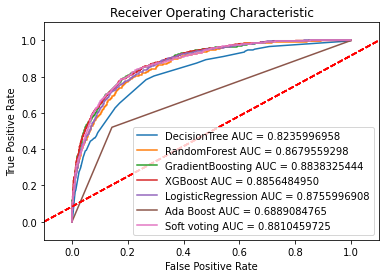

In [ ]:
from sklearn.metrics import roc_auc_score

models2 = []
models2.append(('DecisionTree', gsDT.best_estimator_))
models2.append(('RandomForest', gsRFC.best_estimator_))
models2.append(('GradientBoosting', gsGBC.best_estimator_))
models2.append(('XGBoost', gsXGB.best_estimator_))
models2.append(('LogisticRegression', gsLR.best_estimator_))
#models.append(('SVC_linear', gsSVC_linear.best_estimator_))
models2.append(('Ada Boost', gsAda.best_estimator_))
#models2.append(('Hard voting', hard_voting))
models2.append(('Soft voting', soft_voting))


for name, model in models2:
    print("roc_score: {}".format(roc_auc_score(y_test, model.predict(X_test))))
   
    # calculate the fpr and tpr for all thresholds of the classification
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
 
    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label = '%s AUC = %0.10f' % (name, roc_auc))
    plt.legend(loc = 'lower right')
    plt.plot([-0.1, 1.1], [0, 1],'r--')
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
import pandas as pd
d = {'precision_score': precision_score, 
     'recall_score': recall_score, 
     'f1_score': f1_score,
     'accuracy_score' : accuracy_score
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=['Decision tree', 'Random Forest', 'Gradient Boosting', 'XGBoost', 'Logistic Regression','SVC Linear', 'Ada Boost','Hard Voting', 'Soft Voting'])
df

,Method,precision_score,recall_score,f1_score,accuracy_score
0,Decision tree,0.720000,0.365747,0.485082,0.821667
1,Random Forest,0.759459,0.407837,0.530689,0.834333
2,Gradient Boosting,0.744000,0.539913,0.625736,0.851667
3,XGBoost,0.743852,0.526851,0.616822,0.849667
4,Logistic Regression,0.695481,0.513788,0.590985,0.836667
5,SVC Linear,0.732584,0.473149,0.574956,0.839333
6,Ada Boost,0.520290,0.521045,0.520667,0.779667
7,Hard Voting,0.758621,0.415094,0.536585,0.835333
8,Soft Voting,0.750588,0.462990,0.572711,0.841333


## 5.2 Uczenie głębokie

Najpierw przetwórzmy nasze dane przy pomocy pipelineów

In [ ]:
X_train2 = preprocess_pipeline.transform(X_train)
X_test2 = preprocess_pipeline.transform(X_test)

### 5.2.1 Sieć bez bajerów

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model1 = keras.models.Sequential()
model1.add(layers.Dense(82, input_dim=82, activation='relu'))
model1.add(layers.Dense(41, input_dim=82, activation='relu'))
model1.add(layers.Dense(20, input_dim=82, activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))

model1.compile(loss="binary_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])

history1 = model1.fit(X_train2, y_train, epochs=100, validation_data=(X_test2, y_test))

Epoch 1/100
375/375 [==============================] - 2s 4ms/step - loss: 0.6130 - accuracy: 0.7922 - val_loss: 0.7177 - val_accuracy: 0.7830
Epoch 2/100
375/375 [==============================] - 1s 3ms/step - loss: 0.4959 - accuracy: 0.8116 - val_loss: 0.3740 - val_accuracy: 0.8317
Epoch 3/100
375/375 [==============================] - 1s 3ms/step - loss: 0.4626 - accuracy: 0.8112 - val_loss: 0.3854 - val_accuracy: 0.8363
Epoch 4/100
375/375 [==============================] - 2s 4ms/step - loss: 0.4494 - accuracy: 0.8162 - val_loss: 0.3779 - val_accuracy: 0.8363
Epoch 5/100
375/375 [==============================] - 1s 4ms/step - loss: 0.4291 - accuracy: 0.8226 - val_loss: 0.3657 - val_accuracy: 0.8360
Epoch 6/100
375/375 [==============================] - 1s 3ms/step - loss: 0.3892 - accuracy: 0.8326 - val_loss: 0.4222 - val_accuracy: 0.8170
Epoch 7/100
375/375 [==============================] - 1s 3ms/step - loss: 0.3940 - accuracy: 0.8284 - val_loss: 0.3633 - val_accuracy: 0.8333

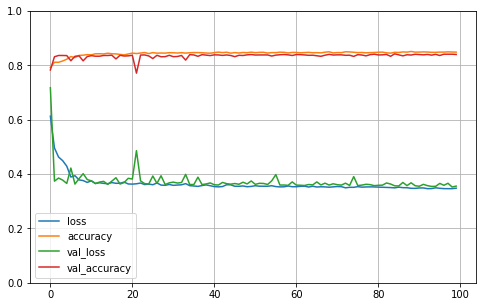

In [ ]:
pd.DataFrame(history1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

### 5.2.2 Sieć z early stoppingiem

In [ ]:
model2 = keras.models.Sequential()
model2.add(layers.Dense(82, input_dim=82, activation='relu'))
model2.add(layers.Dense(41, input_dim=82, activation='relu'))
model2.add(layers.Dense(20, input_dim=82, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(loss="binary_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])


early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
history2 = model2.fit(X_train2, y_train, epochs=100, validation_data=(X_test2, y_test), callbacks=[early_stopping])

Epoch 1/100
375/375 [==============================] - 2s 3ms/step - loss: 1.8954 - accuracy: 0.7772 - val_loss: 0.4272 - val_accuracy: 0.7983
Epoch 2/100
375/375 [==============================] - 1s 3ms/step - loss: 0.4467 - accuracy: 0.8188 - val_loss: 0.4068 - val_accuracy: 0.8103
Epoch 3/100
375/375 [==============================] - 1s 3ms/step - loss: 0.4536 - accuracy: 0.8137 - val_loss: 0.4109 - val_accuracy: 0.8333
Epoch 4/100
375/375 [==============================] - 1s 3ms/step - loss: 0.4418 - accuracy: 0.8199 - val_loss: 0.3800 - val_accuracy: 0.8380
Epoch 5/100
375/375 [==============================] - 1s 3ms/step - loss: 0.4327 - accuracy: 0.8197 - val_loss: 0.3634 - val_accuracy: 0.8350
Epoch 6/100
375/375 [==============================] - 1s 3ms/step - loss: 0.3909 - accuracy: 0.8318 - val_loss: 0.4398 - val_accuracy: 0.7990
Epoch 7/100
375/375 [==============================] - 1s 3ms/step - loss: 0.3961 - accuracy: 0.8309 - val_loss: 0.3626 - val_accuracy: 0.8337

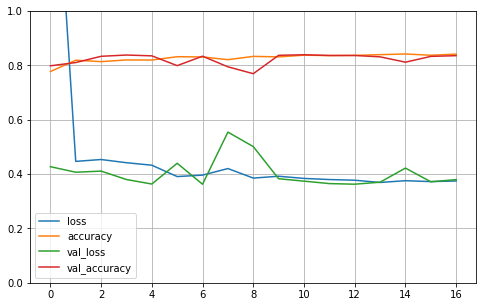

In [ ]:
pd.DataFrame(history2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

### 5.2.3 Sieć z BatchNormalization

In [ ]:
model3 = Sequential()
model3.add(Flatten(input_shape=[82,]))
model3.add(BatchNormalization())
model3.add(Activation('sigmoid'))

model3.add(Dense(300))
model3.add(BatchNormalization())
model3.add(Activation('sigmoid'))

model3.add(Dense(100))
model3.add(BatchNormalization())
model3.add(Activation('sigmoid'))

model3.add(Dense(1))
model3.add(Activation('sigmoid'))

model3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer="sgd",
              metrics=["accuracy"])

history3 = model3.fit(X_train2, y_train, epochs=100, validation_data=(X_test2, y_test))

Epoch 1/100
375/375 [==============================] - 2s 4ms/step - loss: 0.4374 - accuracy: 0.7972 - val_loss: 0.4325 - val_accuracy: 0.7740
Epoch 2/100
375/375 [==============================] - 1s 4ms/step - loss: 0.3912 - accuracy: 0.8291 - val_loss: 0.3828 - val_accuracy: 0.8247
Epoch 3/100
375/375 [==============================] - 1s 4ms/step - loss: 0.3792 - accuracy: 0.8357 - val_loss: 0.3751 - val_accuracy: 0.8313
Epoch 4/100
375/375 [==============================] - 2s 4ms/step - loss: 0.3745 - accuracy: 0.8345 - val_loss: 0.3703 - val_accuracy: 0.8353
Epoch 5/100
375/375 [==============================] - 1s 4ms/step - loss: 0.3682 - accuracy: 0.8389 - val_loss: 0.3669 - val_accuracy: 0.8353
Epoch 6/100
375/375 [==============================] - 1s 4ms/step - loss: 0.3636 - accuracy: 0.8426 - val_loss: 0.3647 - val_accuracy: 0.8377
Epoch 7/100
375/375 [==============================] - 1s 4ms/step - loss: 0.3622 - accuracy: 0.8424 - val_loss: 0.3628 - val_accuracy: 0.8387

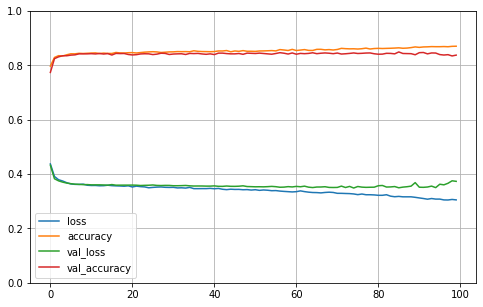

In [ ]:
pd.DataFrame(history3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

### 5.2.4 Sieć z BatchNormalization i Dropoutem

In [ ]:
model4 = Sequential()
model4.add(Flatten(input_shape=[82,]))
model4.add(BatchNormalization())
model4.add(Activation('sigmoid'))
model4.add(Dropout(0.3))

model4.add(Dense(300))
model4.add(BatchNormalization())
model4.add(Activation('sigmoid'))
model4.add(Dropout(0.3))

model4.add(Dense(100))
model4.add(BatchNormalization())
model4.add(Activation('sigmoid'))
model4.add(Dropout(0.3))

model4.add(Dense(1))
model4.add(Activation('sigmoid'))

model4.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer="sgd",
              metrics=["accuracy"])

history4 = model4.fit(X_train2, y_train, epochs=100, validation_data=(X_test2, y_test))

Epoch 1/100
375/375 [==============================] - 2s 4ms/step - loss: 0.5635 - accuracy: 0.7508 - val_loss: 0.5110 - val_accuracy: 0.7703
Epoch 2/100
375/375 [==============================] - 1s 3ms/step - loss: 0.5338 - accuracy: 0.7646 - val_loss: 0.4861 - val_accuracy: 0.7703
Epoch 3/100
375/375 [==============================] - 1s 3ms/step - loss: 0.5229 - accuracy: 0.7676 - val_loss: 0.4708 - val_accuracy: 0.7703
Epoch 4/100
375/375 [==============================] - 1s 4ms/step - loss: 0.5098 - accuracy: 0.7696 - val_loss: 0.4574 - val_accuracy: 0.7703
Epoch 5/100
375/375 [==============================] - 1s 4ms/step - loss: 0.5024 - accuracy: 0.7718 - val_loss: 0.4461 - val_accuracy: 0.7740
Epoch 6/100
375/375 [==============================] - 1s 4ms/step - loss: 0.4991 - accuracy: 0.7724 - val_loss: 0.4368 - val_accuracy: 0.7767
Epoch 7/100
375/375 [==============================] - 1s 4ms/step - loss: 0.4876 - accuracy: 0.7742 - val_loss: 0.4285 - val_accuracy: 0.7833

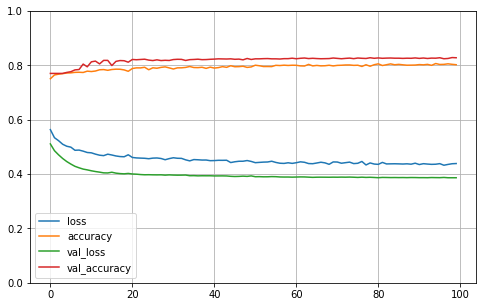

In [ ]:
pd.DataFrame(history4.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

### 5.2.5 Randomized Search

In [ ]:
keras.backend.clear_session()

def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[82,], activation_function='sigmoid'):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation=activation_function))
    model.add(keras.layers.Dense(1))
    
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [ ]:
keras_class = tf.keras.wrappers.scikit_learn.KerasClassifier(build_model)
keras_class

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


In [ ]:
param_distribs = {
    "n_hidden": [2, 3, 4, 5],
    "n_neurons": np.arange(1, 100), 
    "activation_function": ['relu', 'elu', 'sigmoid']
}

rnd_search_cv = RandomizedSearchCV(keras_class, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train2, y_train, epochs=100, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=20, mode='min', verbose=1)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
225/225 [==============================] - 1s 3ms/step - loss: 11.6911 - accuracy: 0.2333 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 2/100
225/225 [==============================] - 0s 2ms/step - loss: 11.6911 - accuracy: 0.2333 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 3/100
225/225 [==============================] - 0s 2ms/step - loss: 11.6911 - accuracy: 0.2333 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 11.6911 - accuracy: 0.2333 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 5/100
225/225 [==============================] - 0s 2ms/step - loss: 11.6911 - accuracy: 0.2333 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 11.6911 - accuracy: 0.2333 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 11.6911 - accuracy: 0.2333 - val_loss: 11.7038 - val_ac

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 2/100
225/225 [==============================] - 0s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 3/100
225/225 [==============================] - 0s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 5/100
225/225 [==============================] - 0s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 11.7186 - accuracy: 0.2315 - val_loss: 11.9325 - val_accuracy: 0.2175
Epoch 2/100
225/225 [==============================] - 0s 2ms/step - loss: 11.7186 - accuracy: 0.2315 - val_loss: 11.9325 - val_accuracy: 0.2175
Epoch 3/100
225/225 [==============================] - 0s 2ms/step - loss: 11.7186 - accuracy: 0.2315 - val_loss: 11.9325 - val_accuracy: 0.2175
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 11.7186 - accuracy: 0.2315 - val_loss: 11.9325 - val_accuracy: 0.2175
Epoch 5/100
225/225 [==============================] - 0s 2ms/step - loss: 11.7186 - accuracy: 0.2315 - val_loss: 11.9325 - val_accuracy: 0.2175
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 11.7186 - accuracy: 0.2315 - val_loss: 11.9325 - val_accuracy: 0.2175
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 11.7186 - accuracy: 0.2315 - val_loss: 11.9325 - val_accuracy: 0.21

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 2/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 3/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 5/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 6/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 7/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 11.6678 - accuracy: 0.2349 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 2/100
225/225 [==============================] - 0s 2ms/step - loss: 11.6678 - accuracy: 0.2349 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 3/100
225/225 [==============================] - 1s 2ms/step - loss: 11.6678 - accuracy: 0.2349 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 11.6678 - accuracy: 0.2349 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 5/100
225/225 [==============================] - 0s 2ms/step - loss: 11.6678 - accuracy: 0.2349 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 6/100
225/225 [==============================] - 1s 2ms/step - loss: 11.6678 - accuracy: 0.2349 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 11.6678 - accuracy: 0.2349 - val_loss: 11.7038 - val_accuracy: 0.23

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 2/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 3/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 5/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 7/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 2/100
225/225 [==============================] - 1s 3ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 3/100
225/225 [==============================] - 1s 3ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 4/100
225/225 [==============================] - 1s 4ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 5/100
225/225 [==============================] - 1s 4ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 6/100
225/225 [==============================] - 1s 3ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 7/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 11.6678 - accuracy: 0.2349 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 2/100
225/225 [==============================] - 1s 3ms/step - loss: 11.6678 - accuracy: 0.2349 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 3/100
225/225 [==============================] - 1s 2ms/step - loss: 11.6678 - accuracy: 0.2349 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 11.6678 - accuracy: 0.2349 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 5/100
225/225 [==============================] - 1s 2ms/step - loss: 11.6678 - accuracy: 0.2349 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 6/100
225/225 [==============================] - 1s 2ms/step - loss: 11.6678 - accuracy: 0.2349 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 7/100
225/225 [==============================] - 1s 2ms/step - loss: 11.6678 - accuracy: 0.2349 - val_loss: 11.7038 - val_accuracy: 0.23

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 2/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 3/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 4/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 5/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 6/100
225/225 [==============================] - 1s 3ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 7/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 2/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 3/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 5/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 2/100
225/225 [==============================] - 1s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 3/100
225/225 [==============================] - 0s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 5/100
225/225 [==============================] - 0s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 2/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 3/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 5/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 2/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 3/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 5/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 11.6678 - accuracy: 0.2349 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 2/100
225/225 [==============================] - 0s 2ms/step - loss: 11.6678 - accuracy: 0.2349 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 3/100
225/225 [==============================] - 1s 2ms/step - loss: 11.6678 - accuracy: 0.2349 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 11.6678 - accuracy: 0.2349 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 5/100
225/225 [==============================] - 1s 2ms/step - loss: 11.6678 - accuracy: 0.2349 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 11.6678 - accuracy: 0.2349 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 11.6678 - accuracy: 0.2349 - val_loss: 11.7038 - val_accuracy: 0.23

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 11.7186 - accuracy: 0.2315 - val_loss: 11.9325 - val_accuracy: 0.2175
Epoch 2/100
225/225 [==============================] - 0s 2ms/step - loss: 11.7186 - accuracy: 0.2315 - val_loss: 11.9325 - val_accuracy: 0.2175
Epoch 3/100
225/225 [==============================] - 0s 2ms/step - loss: 11.7186 - accuracy: 0.2315 - val_loss: 11.9325 - val_accuracy: 0.2175
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 11.7186 - accuracy: 0.2315 - val_loss: 11.9325 - val_accuracy: 0.2175
Epoch 5/100
225/225 [==============================] - 0s 2ms/step - loss: 11.7186 - accuracy: 0.2315 - val_loss: 11.9325 - val_accuracy: 0.2175
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 11.7186 - accuracy: 0.2315 - val_loss: 11.9325 - val_accuracy: 0.2175
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 11.7186 - accuracy: 0.2315 - val_loss: 11.9325 - val_accuracy: 0.21

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 11.6911 - accuracy: 0.2333 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 2/100
225/225 [==============================] - 1s 3ms/step - loss: 11.6911 - accuracy: 0.2333 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 3/100
225/225 [==============================] - 1s 2ms/step - loss: 11.6911 - accuracy: 0.2333 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 4/100
225/225 [==============================] - 1s 2ms/step - loss: 11.6911 - accuracy: 0.2333 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 5/100
225/225 [==============================] - 1s 2ms/step - loss: 11.6911 - accuracy: 0.2333 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 6/100
225/225 [==============================] - 1s 2ms/step - loss: 11.6911 - accuracy: 0.2333 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 7/100
225/225 [==============================] - 1s 2ms/step - loss: 11.6911 - accuracy: 0.2333 - val_loss: 11.7038 - val_accuracy: 0.23

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 0.5464 - accuracy: 0.7651 - val_loss: 0.5391 - val_accuracy: 0.7675
Epoch 2/100
225/225 [==============================] - 1s 2ms/step - loss: 0.5442 - accuracy: 0.7651 - val_loss: 0.5394 - val_accuracy: 0.7675
Epoch 3/100
225/225 [==============================] - 1s 2ms/step - loss: 0.5427 - accuracy: 0.7651 - val_loss: 0.5347 - val_accuracy: 0.7675
Epoch 4/100
225/225 [==============================] - 1s 2ms/step - loss: 0.5406 - accuracy: 0.7651 - val_loss: 0.5351 - val_accuracy: 0.7675
Epoch 5/100
225/225 [==============================] - 1s 2ms/step - loss: 0.5406 - accuracy: 0.7651 - val_loss: 0.5431 - val_accuracy: 0.7675
Epoch 6/100
225/225 [==============================] - 1s 2ms/step - loss: 0.5397 - accuracy: 0.7651 - val_loss: 0.5400 - val_accuracy: 0.7675
Epoch 7/100
225/225 [==============================] - 1s 2ms/step - loss: 0.5358 - accuracy: 0.7651 - val_loss: 0.5294 - val_accuracy: 0.7675
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 2/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 3/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 4/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 5/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 6/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 7/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 2/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 3/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 5/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 11.6678 - accuracy: 0.2349 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 2/100
225/225 [==============================] - 0s 2ms/step - loss: 11.6678 - accuracy: 0.2349 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 3/100
225/225 [==============================] - 0s 2ms/step - loss: 11.6678 - accuracy: 0.2349 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 11.6678 - accuracy: 0.2349 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 5/100
225/225 [==============================] - 0s 2ms/step - loss: 11.6678 - accuracy: 0.2349 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 11.6678 - accuracy: 0.2349 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 11.6678 - accuracy: 0.2349 - val_loss: 11.7038 - val_accuracy: 0.23

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 2s 3ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 2/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 3/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 5/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 11.6911 - accuracy: 0.2333 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 2/100
225/225 [==============================] - 0s 2ms/step - loss: 11.6911 - accuracy: 0.2333 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 3/100
225/225 [==============================] - 0s 2ms/step - loss: 11.6911 - accuracy: 0.2333 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 11.6911 - accuracy: 0.2333 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 5/100
225/225 [==============================] - 1s 2ms/step - loss: 11.6911 - accuracy: 0.2333 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 6/100
225/225 [==============================] - 1s 2ms/step - loss: 11.6911 - accuracy: 0.2333 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 7/100
225/225 [==============================] - 1s 2ms/step - loss: 11.6911 - accuracy: 0.2333 - val_loss: 11.7038 - val_accuracy: 0.23

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 2/100
225/225 [==============================] - 0s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 3/100
225/225 [==============================] - 0s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 4/100
225/225 [==============================] - 1s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 5/100
225/225 [==============================] - 0s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 11.7186 - accuracy: 0.2315 - val_loss: 11.9325 - val_accuracy: 0.2175
Epoch 2/100
225/225 [==============================] - 0s 2ms/step - loss: 11.7186 - accuracy: 0.2315 - val_loss: 11.9325 - val_accuracy: 0.2175
Epoch 3/100
225/225 [==============================] - 0s 2ms/step - loss: 11.7186 - accuracy: 0.2315 - val_loss: 11.9325 - val_accuracy: 0.2175
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 11.7186 - accuracy: 0.2315 - val_loss: 11.9325 - val_accuracy: 0.2175
Epoch 5/100
225/225 [==============================] - 0s 2ms/step - loss: 11.7186 - accuracy: 0.2315 - val_loss: 11.9325 - val_accuracy: 0.2175
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 11.7186 - accuracy: 0.2315 - val_loss: 11.9325 - val_accuracy: 0.2175
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 11.7186 - accuracy: 0.2315 - val_loss: 11.9325 - val_accuracy: 0.21

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 0.5472 - accuracy: 0.7667 - val_loss: 0.5437 - val_accuracy: 0.7675
Epoch 2/100
225/225 [==============================] - 1s 2ms/step - loss: 0.5485 - accuracy: 0.7667 - val_loss: 0.5472 - val_accuracy: 0.7675
Epoch 3/100
225/225 [==============================] - 0s 2ms/step - loss: 0.5484 - accuracy: 0.7667 - val_loss: 0.5425 - val_accuracy: 0.7675
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 0.5473 - accuracy: 0.7667 - val_loss: 0.5648 - val_accuracy: 0.7675
Epoch 5/100
225/225 [==============================] - 0s 2ms/step - loss: 0.5463 - accuracy: 0.7667 - val_loss: 0.5404 - val_accuracy: 0.7675
Epoch 6/100
225/225 [==============================] - 1s 2ms/step - loss: 0.5463 - accuracy: 0.7667 - val_loss: 0.5501 - val_accuracy: 0.7675
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 0.5443 - accuracy: 0.7667 - val_loss: 0.5566 - val_accuracy: 0.7675
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 2/100
225/225 [==============================] - 1s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 3/100
225/225 [==============================] - 1s 3ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 4/100
225/225 [==============================] - 1s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 5/100
225/225 [==============================] - 1s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 6/100
225/225 [==============================] - 1s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 7/100
225/225 [==============================] - 1s 3ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 2/100
225/225 [==============================] - 1s 3ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 3/100
225/225 [==============================] - 1s 3ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 4/100
225/225 [==============================] - 1s 3ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 5/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 6/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 7/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 3.6081 - accuracy: 0.7657 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 2/100
225/225 [==============================] - 1s 3ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 3/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 4/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 5/100
225/225 [==============================] - 1s 3ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 6/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 2/100
225/225 [==============================] - 1s 3ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 3/100
225/225 [==============================] - 1s 3ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 4/100
225/225 [==============================] - 1s 3ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 5/100
225/225 [==============================] - 1s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 7/100
225/225 [==============================] - 1s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 7.5984 - accuracy: 0.5029 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 2/100
225/225 [==============================] - 1s 3ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 3/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 4/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 5/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 7/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 8/100

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f6fbcd55d10>,
                   param_distributions={'activation_function': ['relu', 'elu',
                                                                'sigmoid'],
                                        'n_hidden': [2, 3, 4, 5],
                                        'n_neurons': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
                   verbose=2)

In [ ]:
rnd_search_cv.best_params_

{'activation_function': 'sigmoid', 'n_hidden': 2, 'n_neurons': 65}

### 5.2.6. Porównanie modeli głębokich

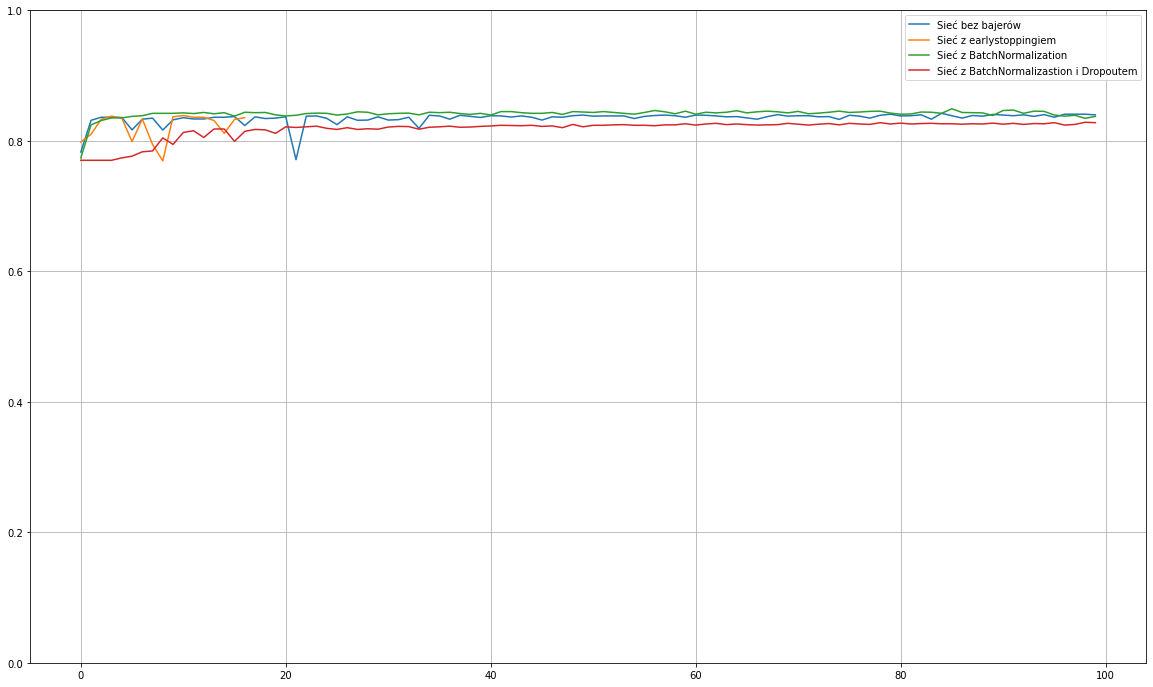

In [ ]:
plt.plot(pd.DataFrame(history1.history['val_accuracy']), label='Sieć bez bajerów')
plt.plot(pd.DataFrame(history2.history['val_accuracy']), label='Sieć z earlystoppingiem')
plt.plot(pd.DataFrame(history3.history['val_accuracy']), label='Sieć z BatchNormalization')
plt.plot(pd.DataFrame(history4.history['val_accuracy']), label='Sieć z BatchNormalizastion i Dropoutem')
plt.legend()
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.rcParams["figure.figsize"] = (25,12)
plt.show()

